#1. Importing Relevant libraries

> Add blockquote



In [ ]:
!pip install dask[dataframe]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from os import truncate
import lightgbm as lgbm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import os
import missingno as msno
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import *

%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2. Data Loading

In [ ]:
def data_loader(filepath:str) -> tuple:
  """
  This function is responsible for loading the required csv files into pyspark dataframes
  """
  try:
      # Load application_train.csv
      appl_train = pd.read_csv(os.path.join(filepath, "application_train.csv"))
      print("Pandas dataframe 'application_train' loaded successfully")

      # Load previous_application.csv
      prev_appl = pd.read_csv(os.path.join(filepath,"previous_application.csv"))
      print("Pandas dataframe 'previous_application' loaded successfully")

      # Load previous_application.csv
      appl_test = pd.read_csv(os.path.join(filepath,"application_test.csv"))
      print("Pandas dataframe 'application_test' loaded successfully")

      return appl_train, prev_appl, appl_test

  except FileNotFoundError as fnf_error:
        print(f"File not found: {fnf_error}")
  except pd.errors.EmptyDataError as ede:
      print(f"Empty data error: {ede}")
  except Exception as e:
      print(f"An error occurred while loading data: {e}")

  return None, None


In [ ]:
filepath = "/content/drive/MyDrive/Home-credit-default-risk-prediction/Data"
appl_train, prev_appl, appl_test = data_loader(filepath)

Pandas dataframe 'application_train' loaded successfully
Pandas dataframe 'previous_application' loaded successfully
Pandas dataframe 'application_test' loaded successfully


In [ ]:
#display the two dataframes
appl_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
## Some utility functions

#Table shape
def pandas_df_shape(df) -> None:
  """
  This function is responsible for accepting a pysaprk dataframe and printing out the number of rows and columns of the dataset
  """
  num_rows = df.shape[0]  # Get number of rows
  num_cols = df.shape[1] # Get number of columns

  # Print the shape (rows, columns)
  print(f"Shape of DataFrame : ({num_rows}, {num_cols})")

#funct to check skewness in each column
def check_skewness(df: pd.DataFrame, col_name: str) -> None:
    print(df[col_name].value_counts())
    percentage_counts = df[col_name].value_counts(normalize=True) * 100
    print(percentage_counts)

#func to check fillrate for each col of whole dataset
def calculate_fill_rate(df: pd.DataFrame) -> pd.DataFrame:
    #check fillrate
    fill_rates = {
        'Column Name': [],
        'Fill Rate (%)': []
    }
    total_rows = df.shape[0]

    for column in df.columns:
        non_null_count = df[column].notnull().sum()
        fill_rate = (non_null_count / total_rows) * 100
        fill_rates['Column Name'].append(column)
        fill_rates['Fill Rate (%)'].append(fill_rate)

    fill_rate_df = pd.DataFrame(fill_rates)

    # # Save the fill rate DataFrame to a CSV file
    # fill_rate_df.to_csv(output_file, index=False)

    return pd.DataFrame(fill_rate_df)


# func to make a plot to check distribution of a variable
def plot_distribution(df: pd.DataFrame, target_variable : str) -> None:
    plt.figure(figsize=(15, 6))

    # Histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[target_variable], bins=30, kde=False, color='blue', edgecolor='black')
    plt.title(f'Histogram of {target_variable}')
    plt.xlabel(target_variable)
    plt.ylabel('Frequency')

    # KDE Plot
    plt.subplot(1, 3, 2)
    sns.kdeplot(df[target_variable], color='red', fill=True)
    plt.title(f'KDE Plot of {target_variable}')
    plt.xlabel(target_variable)
    plt.ylabel('Density')

    # Box Plot
    plt.subplot(1, 3, 3)
    sns.boxplot(x=df[target_variable], color='lightgray')
    plt.title(f'Box Plot of {target_variable}')
    plt.xlabel(target_variable)

    plt.tight_layout()
    plt.show()


#3. Basic Data Exploration

In [ ]:
#Dataset Shape
pandas_df_shape(appl_train)
pandas_df_shape(prev_appl)

Shape of DataFrame : (307511, 122)
Shape of DataFrame : (1670214, 37)


In [ ]:
# Distribution of the target variable
check_skewness(appl_train, 'TARGET')

TARGET
0    282686
1     24825
Name: count, dtype: int64
TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64




```
# This is formatted as code
```

# 4. Data Cleaning

In [ ]:
fill_rate_df_app_train = calculate_fill_rate(appl_train)
fill_rate_df_app_train

,Column Name,Fill Rate (%)
0,SK_ID_CURR,100.000000
1,TARGET,100.000000
2,NAME_CONTRACT_TYPE,100.000000
3,CODE_GENDER,100.000000
4,FLAG_OWN_CAR,100.000000
...,...,...
117,AMT_REQ_CREDIT_BUREAU_DAY,86.498369
118,AMT_REQ_CREDIT_BUREAU_WEEK,86.498369
119,AMT_REQ_CREDIT_BUREAU_MON,86.498369
120,AMT_REQ_CREDIT_BUREAU_QRT,86.498369


## 4.1 Data Imputation

The Plan is to take only the columns which have > 50% fillrate but < 100% fillrate and then find a way to impute the missing values. Right now I am not going to bother dealing with the columns with <= 50 % fillrate and will just drop them.

In this code, I am only concerned with imputing the important variables like AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, OCCUPATION_TYPE, CNT_FAM_MEMBERS (handling them are part of my task list in the project) I am planning to build machine learning models to find the optimal values for the missing cases. Since we have about 300,000+ rows in appl_train dataset, this gives me the confidence that building imputation models are feasible.

### 2 Possible approaches for the above

1. Approach 1 - Even after dropping columsn with <= 50% fillrate, their will still be lots of columns with > 50% but less than 100% fillrate. One possible way of fealing with these columns (for imputation model) is just dropping them. I can brign these columns back while building the main models. This will give us the freedom to use any machine learning model for imputation, even the likes of linear and logistic regression etc which are very sensitive to missing data.

2. Approach 2 - Keep all the columns intact, dont drop any columns (other than <= 50 % fillrate columns) . Proceed with the normal flow of machine learning modelling but only restrict myself to models that can handle missing data on its own like XGB etc.

In [ ]:
# dropping columns with <= 50% fillrate

# make a list of all columns with <= 50% fillrate
low_fill_rate_columns = fill_rate_df_app_train[fill_rate_df_app_train['Fill Rate (%)'] <= 50.00]['Column Name'].tolist()
low_fill_rate_columns

['OWN_CAR_AGE',
 'EXT_SOURCE_1',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE']

In [ ]:
# dropping these columns from appl_train datafram
appl_train_refined = appl_train.drop(columns = low_fill_rate_columns)

In [ ]:
appl_train_refined.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## 4.2 EDA for the imputation Model

My first imputation model will be focused on the target Variabe - **AMT_ANNUITY**

AMT_ANNUITY represents - Loan Annuity for the particular loan application

In [ ]:
pandas_df_shape(appl_train_refined)

Shape of DataFrame : (307511, 81)


In [ ]:
# how many null values are there for the target variable
null_count = appl_train_refined['AMT_ANNUITY'].isnull().sum()
print(f"Number of null values in 'AMT_ANNUITY': {null_count}")

Number of null values in 'AMT_ANNUITY': 12


So the number of null values are just 12 for a dataset of 300,000+. Doing imputation for this seems like an over kill, but another analysis proved that this variable was of utmost importance for predicting defaults hence proceeding with the same.


Let us try to get an idea of the distribution of the target variable

In [ ]:
appl_train_refined['AMT_ANNUITY'].describe()

,AMT_ANNUITY
count,307499.000000
mean,27108.573909
std,14493.737315
min,1615.500000
25%,16524.000000
50%,24903.000000
75%,34596.000000
max,258025.500000


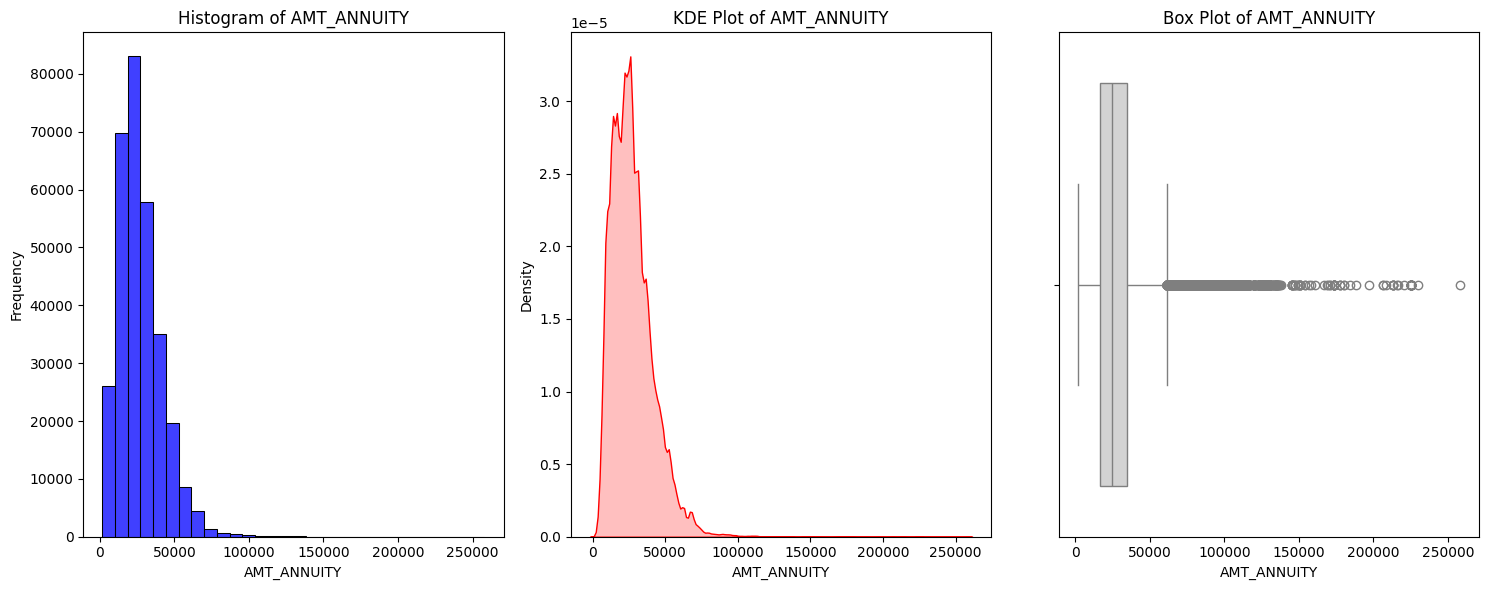

In [ ]:
plot_distribution(appl_train_refined,'AMT_ANNUITY')

### 4.3 Inference about the Distribution of the Target Variable - AMT_ANNUITY
The variable AMT_ANNUITY is not normally distributed.

Histogram: The data shows a right-skewed (positively skewed) distribution. Most of the values are concentrated toward the lower end (closer to 0), with fewer occurrences of higher values, which is typical of skewness.

KDE Plot: The Kernel Density Estimate (KDE) confirms the right-skew, with a sharp peak around the lower values and a long tail extending toward higher values. This long tail suggests the presence of some higher outliers.

Box Plot: The box plot further highlights the skewness, as the median is closer to the lower quartile, and there are many outliers on the right-hand side (values much higher than the rest).

Overall, the distribution of AMT_ANNUITY is right-skewed, with most values concentrated in the lower range, and a few higher values (outliers) extending toward the upper range.

In [ ]:
appl_train_refined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    307511 non-null  int64  
 1   TARGET                        307511 non-null  int64  
 2   NAME_CONTRACT_TYPE            307511 non-null  object 
 3   CODE_GENDER                   307511 non-null  object 
 4   FLAG_OWN_CAR                  307511 non-null  object 
 5   FLAG_OWN_REALTY               307511 non-null  object 
 6   CNT_CHILDREN                  307511 non-null  int64  
 7   AMT_INCOME_TOTAL              307511 non-null  float64
 8   AMT_CREDIT                    307511 non-null  float64
 9   AMT_ANNUITY                   307499 non-null  float64
 10  AMT_GOODS_PRICE               307233 non-null  float64
 11  NAME_TYPE_SUITE               306219 non-null  object 
 12  NAME_INCOME_TYPE              307511 non-nul

In [ ]:
# Identify all the categorical variables
categorical_columns = appl_train_refined.select_dtypes(include=['object', 'category']).columns.tolist()

# Identify numerical variables (usually of type 'int64' or 'float64')
numerical_columns = appl_train_refined.select_dtypes(include=['int64', 'float64']).columns.tolist()


print("Categorical Variables:", categorical_columns)
print("Numerical Variables:", numerical_columns)

Categorical Variables: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE']
Numerical Variables: ['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_

In [ ]:
# printing all the categorical columns
categorical_appl_train_refined = appl_train_refined[categorical_columns]
categorical_appl_train_refined.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN


## 4.4 Feature Engineering for Imputation model

Now lets do some basic feature engineering to identify important features and drop useless features

### Encoding Categorical variables

Since my plan is to use a tree based algorithm for the imputation model. It will be a reasonable choice to use label encoding instead of OneHotEncoding as tree based algorithms are not sensitive to absolute magnitude of the encoded values

In [ ]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Loop through each specified column and apply label encoding
for column in categorical_columns:
    categorical_appl_train_refined[column + '_encoded'] = np.where(categorical_appl_train_refined[column].isnull(),
                                   np.nan, label_encoder.fit_transform(categorical_appl_train_refined[column]))


categorical_appl_train_refined.head(2)

<ipython-input-21-fc80b82bcd82>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_appl_train_refined[column + '_encoded'] = np.where(categorical_appl_train_refined[column].isnull(),
<ipython-input-21-fc80b82bcd82>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_appl_train_refined[column + '_encoded'] = np.where(categorical_appl_train_refined[column].isnull(),
<ipython-input-21-fc80b82bcd82>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,...,FLAG_OWN_REALTY_encoded,NAME_TYPE_SUITE_encoded,NAME_INCOME_TYPE_encoded,NAME_EDUCATION_TYPE_encoded,NAME_FAMILY_STATUS_encoded,NAME_HOUSING_TYPE_encoded,OCCUPATION_TYPE_encoded,WEEKDAY_APPR_PROCESS_START_encoded,ORGANIZATION_TYPE_encoded,EMERGENCYSTATE_MODE_encoded
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,...,1.0,6.0,7.0,4.0,3.0,1.0,8.0,6.0,5.0,0.0
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,...,0.0,1.0,4.0,1.0,1.0,1.0,3.0,1.0,39.0,0.0


In [ ]:
# dropping non encoded columns
categorical_appl_train_refined.drop(columns = categorical_columns,inplace=True)
categorical_appl_train_refined.head(2)

<ipython-input-22-a9cb0059ca24>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_appl_train_refined.drop(columns = categorical_columns,inplace=True)


,NAME_CONTRACT_TYPE_encoded,CODE_GENDER_encoded,FLAG_OWN_CAR_encoded,FLAG_OWN_REALTY_encoded,NAME_TYPE_SUITE_encoded,NAME_INCOME_TYPE_encoded,NAME_EDUCATION_TYPE_encoded,NAME_FAMILY_STATUS_encoded,NAME_HOUSING_TYPE_encoded,OCCUPATION_TYPE_encoded,WEEKDAY_APPR_PROCESS_START_encoded,ORGANIZATION_TYPE_encoded,EMERGENCYSTATE_MODE_encoded
0,0.0,1.0,0.0,1.0,6.0,7.0,4.0,3.0,1.0,8.0,6.0,5.0,0.0
1,0.0,0.0,0.0,0.0,1.0,4.0,1.0,1.0,1.0,3.0,1.0,39.0,0.0


In [ ]:
# merging the encoded categorical variables in main df

appl_train_2 = pd.concat([appl_train_refined,categorical_appl_train_refined], axis = 1)
appl_train_2.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_OWN_REALTY_encoded,NAME_TYPE_SUITE_encoded,NAME_INCOME_TYPE_encoded,NAME_EDUCATION_TYPE_encoded,NAME_FAMILY_STATUS_encoded,NAME_HOUSING_TYPE_encoded,OCCUPATION_TYPE_encoded,WEEKDAY_APPR_PROCESS_START_encoded,ORGANIZATION_TYPE_encoded,EMERGENCYSTATE_MODE_encoded
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,1.0,6.0,7.0,4.0,3.0,1.0,8.0,6.0,5.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,1.0,4.0,1.0,1.0,1.0,3.0,1.0,39.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,1.0,6.0,7.0,4.0,3.0,1.0,8.0,1.0,11.0,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,1.0,6.0,7.0,4.0,0.0,1.0,8.0,6.0,5.0,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,6.0,7.0,4.0,3.0,1.0,3.0,4.0,37.0,NaN


In [ ]:
# drop non encoded categorical columns from appl_train_2
appl_train_2.drop(columns = categorical_columns,inplace=True)
appl_train_2.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_OWN_REALTY_encoded,NAME_TYPE_SUITE_encoded,NAME_INCOME_TYPE_encoded,NAME_EDUCATION_TYPE_encoded,NAME_FAMILY_STATUS_encoded,NAME_HOUSING_TYPE_encoded,OCCUPATION_TYPE_encoded,WEEKDAY_APPR_PROCESS_START_encoded,ORGANIZATION_TYPE_encoded,EMERGENCYSTATE_MODE_encoded
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,1.0,6.0,7.0,4.0,3.0,1.0,8.0,6.0,5.0,0.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0.0,1.0,4.0,1.0,1.0,1.0,3.0,1.0,39.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,1.0,6.0,7.0,4.0,3.0,1.0,8.0,1.0,11.0,NaN
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,1.0,6.0,7.0,4.0,0.0,1.0,8.0,6.0,5.0,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,1.0,6.0,7.0,4.0,3.0,1.0,3.0,4.0,37.0,NaN


In [ ]:
#changing all the columns to float
appl_train_2 = appl_train_2.astype(float)

### 4.5 Correlation Matrix

Now that all variables have been brought to the same type (float). We will try to identify the correlation between variables through a correlation matrix. After this step, we can proceed with dropping certain features which have very weak correlation with AMT_ANNUITY and merge variables which have very strong correlation with each other

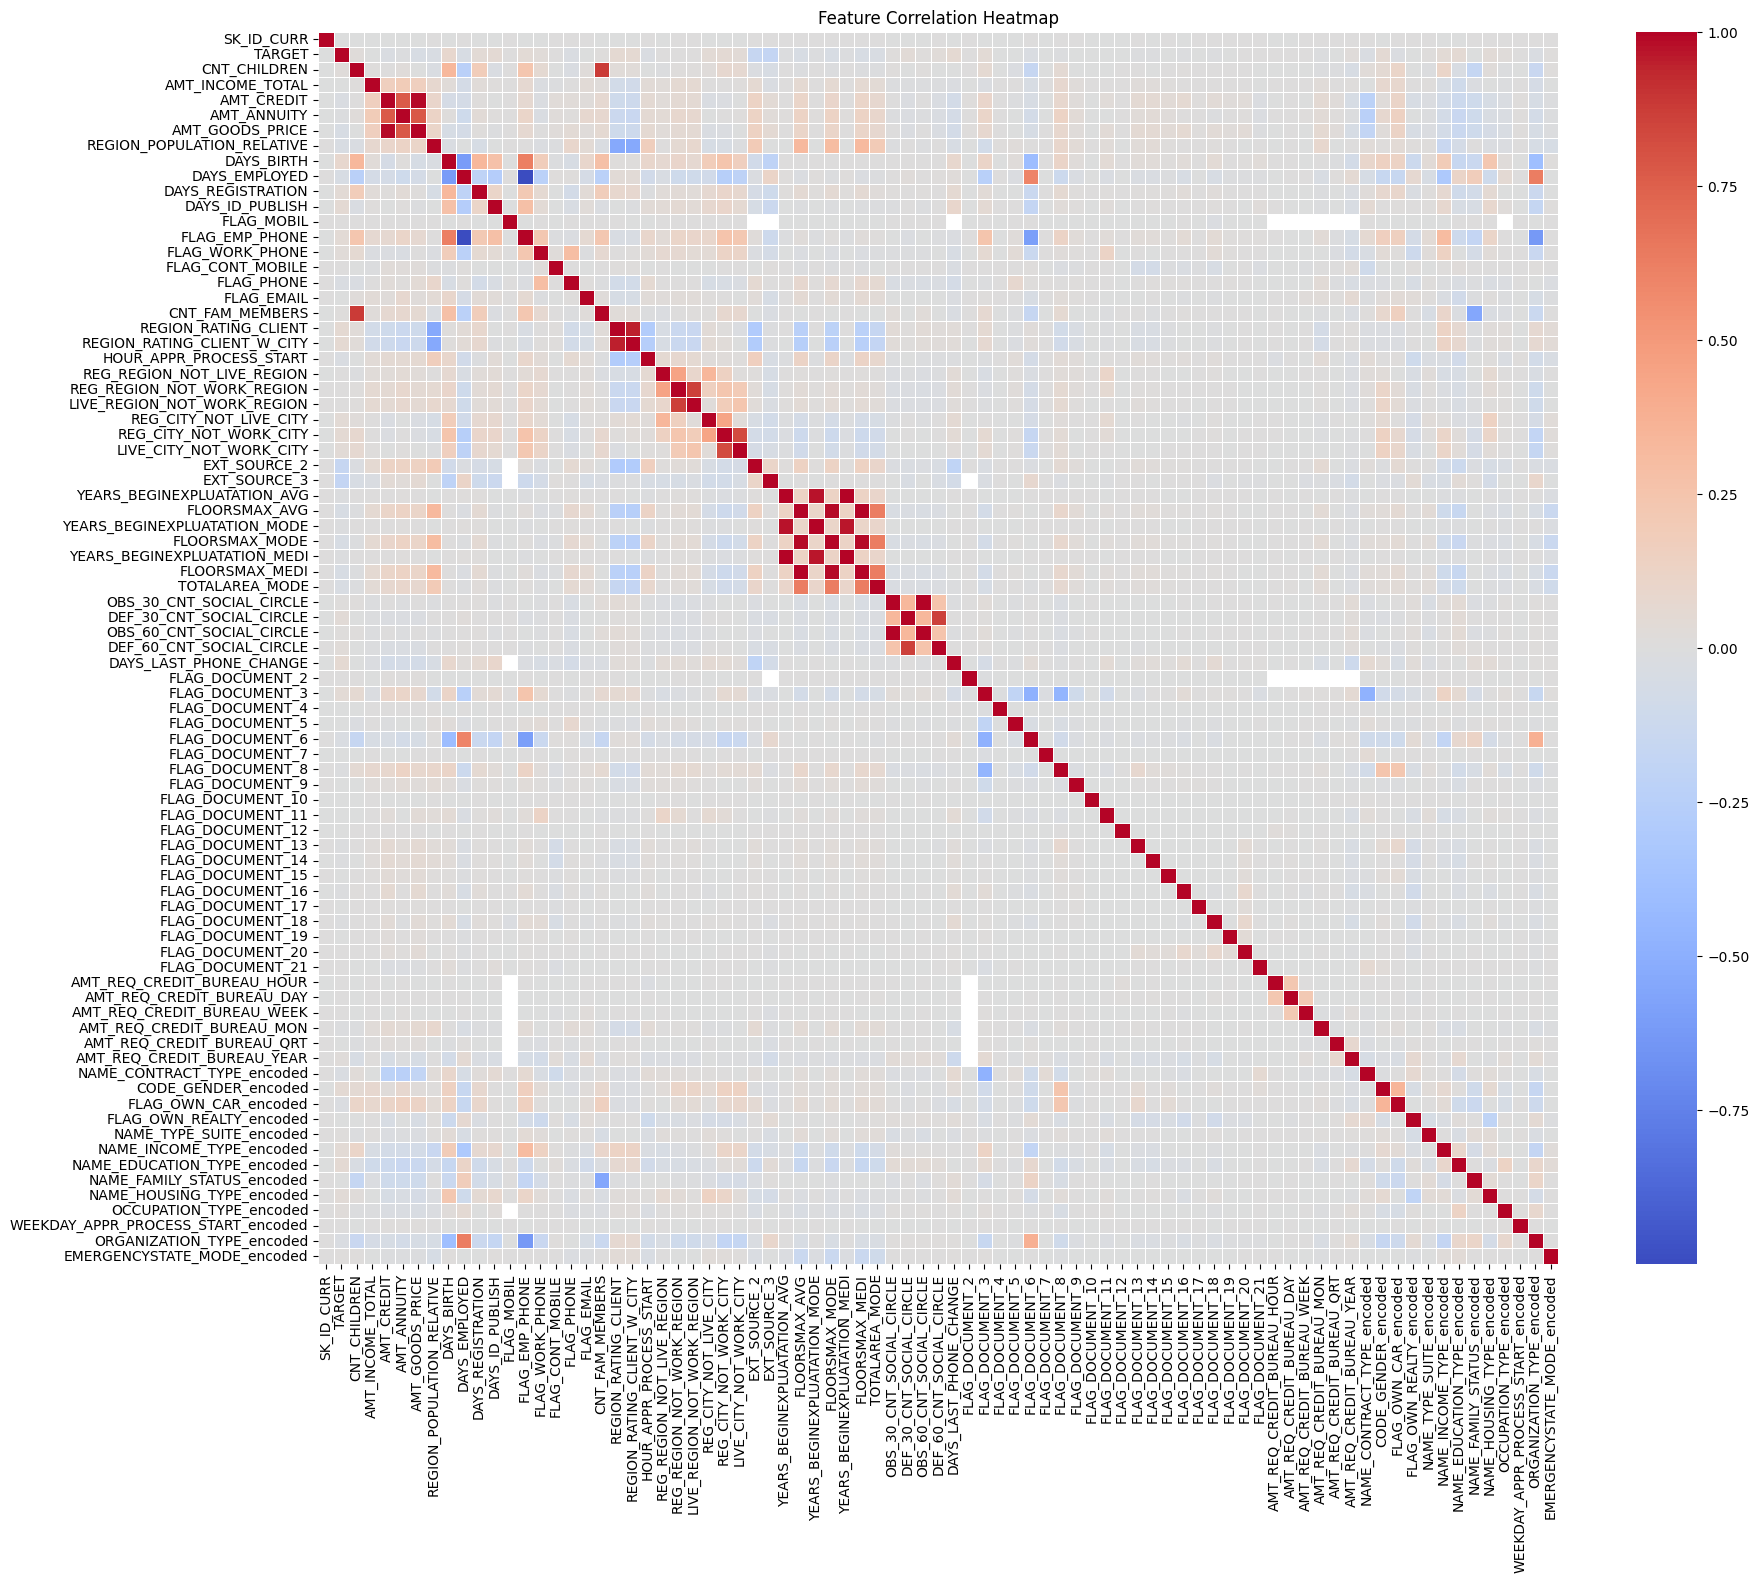

In [ ]:
# Calculate the correlation matrix
correlation_matrix = appl_train_2.corr()

# Create the heatmap
plt.figure(figsize=(20, 16))  # You can adjust the size depending on the number of features
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Feature Correlation Heatmap')
plt.show()

Its very difficult to make any inference from the above heatmap as most values fall in the gray range. Hence to make a better visualization, I want to filter out some of the weak correlated values. Also I am interested to see the distrbution of values in the correlation matric itself

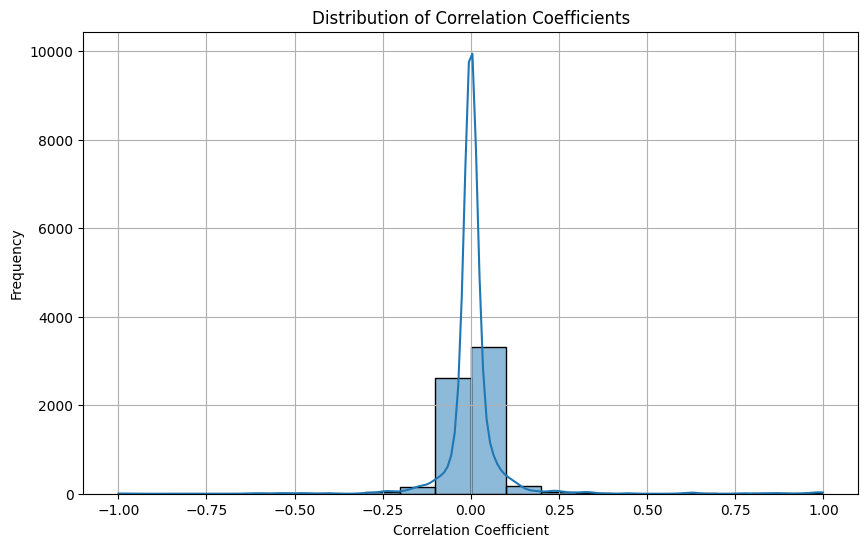

In [ ]:
# Flatten the correlation matrix and filter out the 1.0 values (self-correlation)
correlation_values = correlation_matrix.values.flatten()
correlation_values = correlation_values[correlation_values != 1.0]  # Exclude self-correlations

plt.figure(figsize=(10, 6))
sns.histplot(correlation_values, bins=20, kde=True)
plt.title('Distribution of Correlation Coefficients')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid()
plt.show()

From the graph, 0.05 seems to be a reasonable cut off.
Therefore, I am dropping all the columns from the dataset that have a correlation value of <= 0.05 with AMT_ANNUITY

In [ ]:
correlation_with_amt_annuity = correlation_matrix['AMT_ANNUITY']

# Identify columns to drop (correlation <= 0.05)
columns_to_drop = correlation_with_amt_annuity[abs(correlation_with_amt_annuity) <= 0.05].index.tolist()

# Drop those columns from the DataFrame
appl_train_3 = appl_train_2.drop(columns=columns_to_drop)

In [ ]:
appl_train_3.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,FLAG_EMP_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,...,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,NAME_CONTRACT_TYPE_encoded,CODE_GENDER_encoded,FLAG_OWN_CAR_encoded,NAME_INCOME_TYPE_encoded,NAME_EDUCATION_TYPE_encoded,NAME_FAMILY_STATUS_encoded,ORGANIZATION_TYPE_encoded
0,202500.0,406597.5,24700.5,351000.0,0.018801,-637.0,1.0,0.0,1.0,2.0,...,1.0,0.0,0.0,0.0,1.0,0.0,7.0,4.0,3.0,5.0
1,270000.0,1293502.5,35698.5,1129500.0,0.003541,-1188.0,1.0,0.0,2.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,39.0
2,67500.0,135000.0,6750.0,135000.0,0.010032,-225.0,1.0,0.0,1.0,2.0,...,0.0,0.0,0.0,1.0,1.0,1.0,7.0,4.0,3.0,11.0
3,135000.0,312682.5,29686.5,297000.0,0.008019,-3039.0,1.0,0.0,2.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,7.0,4.0,0.0,5.0
4,121500.0,513000.0,21865.5,513000.0,0.028663,-3038.0,1.0,0.0,1.0,2.0,...,0.0,0.0,1.0,0.0,1.0,0.0,7.0,4.0,3.0,37.0


In [ ]:
appl_train_3.shape

(307511, 30)

We have reduced the dataset drastically from 94 columns to just 30 columns. I am not sure if selecting threshold of 0.1 was a good idea or not. But we will see

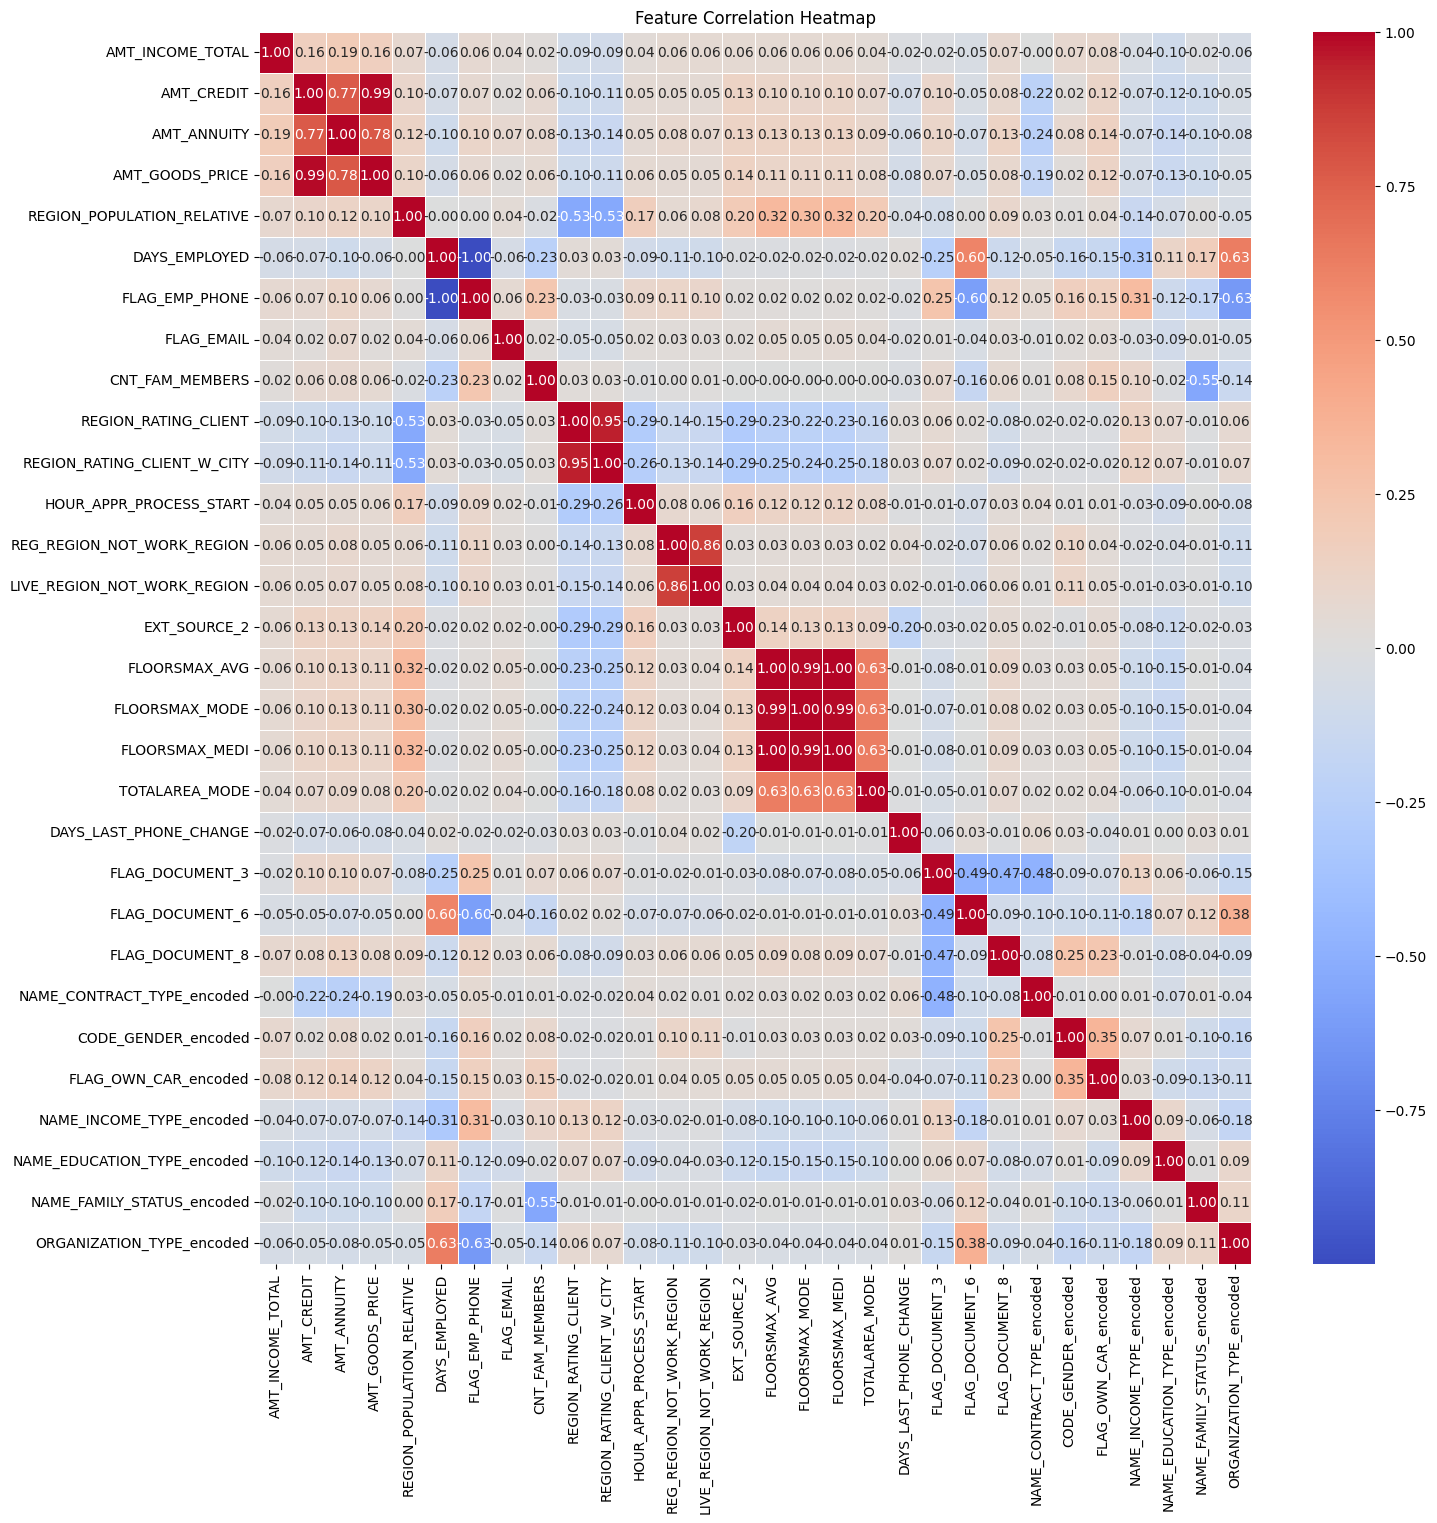

In [ ]:
# Calculate the correlation matrix
correlation_matrix2 = appl_train_3.corr()

# Create the heatmap
plt.figure(figsize=(16, 16))  # You can adjust the size depending on the number of features
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Feature Correlation Heatmap')
plt.show()

#### **Observations and Inferences from the Correlation MAtrix**

1. The 2 features that show the strongest correlation with our target "AMT_ANNUITY" is AMT_CREDIT and AMT_GOODS_PRICE with correlation values of 0.77 and 0.88 respectively.

    * AMT_CREDIT - Credit amount of the loan
    * AMT_GOODS_PRICE - For consumer loans it is the price of the goods for which the loan is given


2. However, when we see the correlation with these 2 variables against each other, we find that they have a correlation of 0.99

3. The above implies that if we allow both variables to stay in the training data, it could lead to a problem of collinearity

4. Hence I am making the decision to merge these 2 features into a single feature. We will explore how to merge them in a sensible way in the following cells

5. We can similar problems of very strong correlation among 2 other groups of variables -

      * group 1 - (FLOORSMAX_AVG, FLOORSMAX_MODE, FLOORSMAX_MEDI) - These are measures of central tendency, hence there is no point merging them instead we will choose any one and drop the other 2

      * group 2 - (REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY) - These are 2 diff ways to represent the same information i.e - rating of the region where client lives (1,2,3). Hence we will pick the REGION_RATING_CLIENT_W_CITY and drop the other one as REGION_RATING_CLIENT_W_CITY includes the clients cities also not just region so its more accurate data

That is about all, now we can make the above changes and proceed with data preparation

In [ ]:

# merging the columns AMT_CREDIT and AMT_GOODS_PRICE

# First explore the value counts  of each
print(appl_train_3[['AMT_CREDIT','AMT_GOODS_PRICE']].describe())

#checking for null values
print("Null value count in AMT_CREDIT : ", appl_train_3['AMT_CREDIT'].isnull().sum())
print("Null value count in AMT_GOODS_PRICE : ",appl_train_3['AMT_GOODS_PRICE'].isnull().sum())


         AMT_CREDIT  AMT_GOODS_PRICE
count  3.075110e+05     3.072330e+05
mean   5.990260e+05     5.383962e+05
std    4.024908e+05     3.694465e+05
min    4.500000e+04     4.050000e+04
25%    2.700000e+05     2.385000e+05
50%    5.135310e+05     4.500000e+05
75%    8.086500e+05     6.795000e+05
max    4.050000e+06     4.050000e+06
Null value count in AMT_CREDIT :  0
Null value count in AMT_GOODS_PRICE :  278


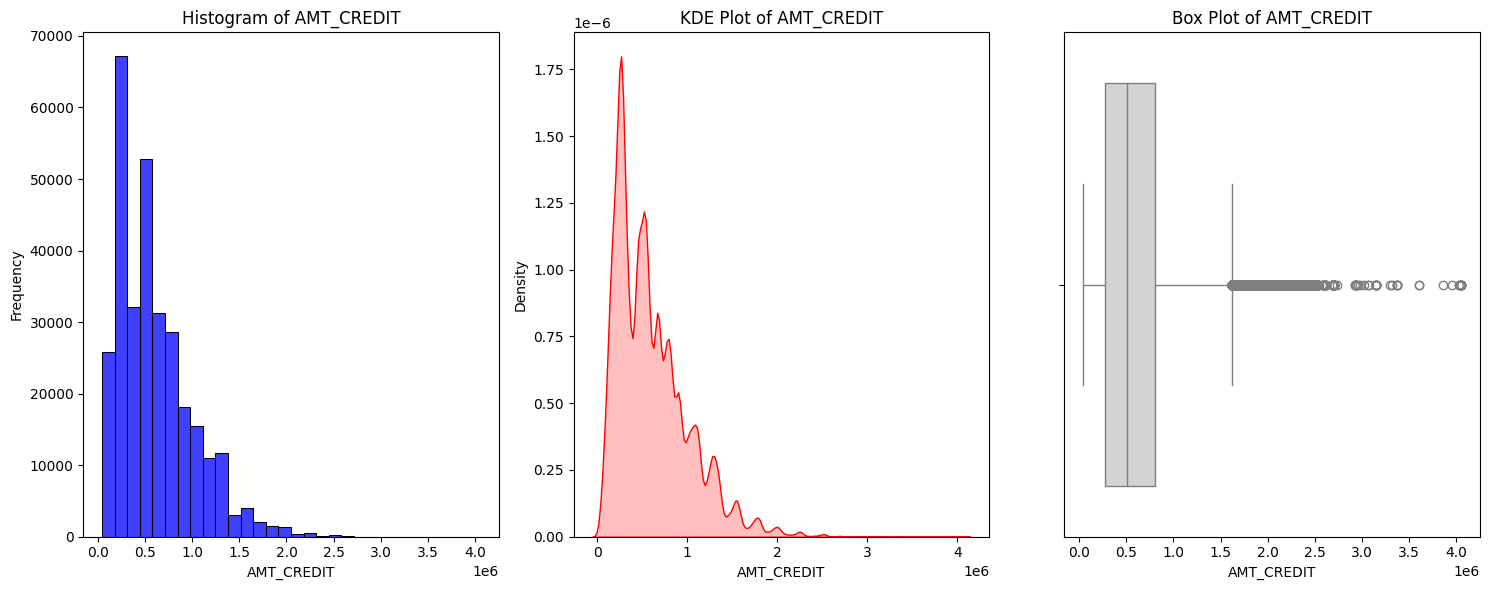

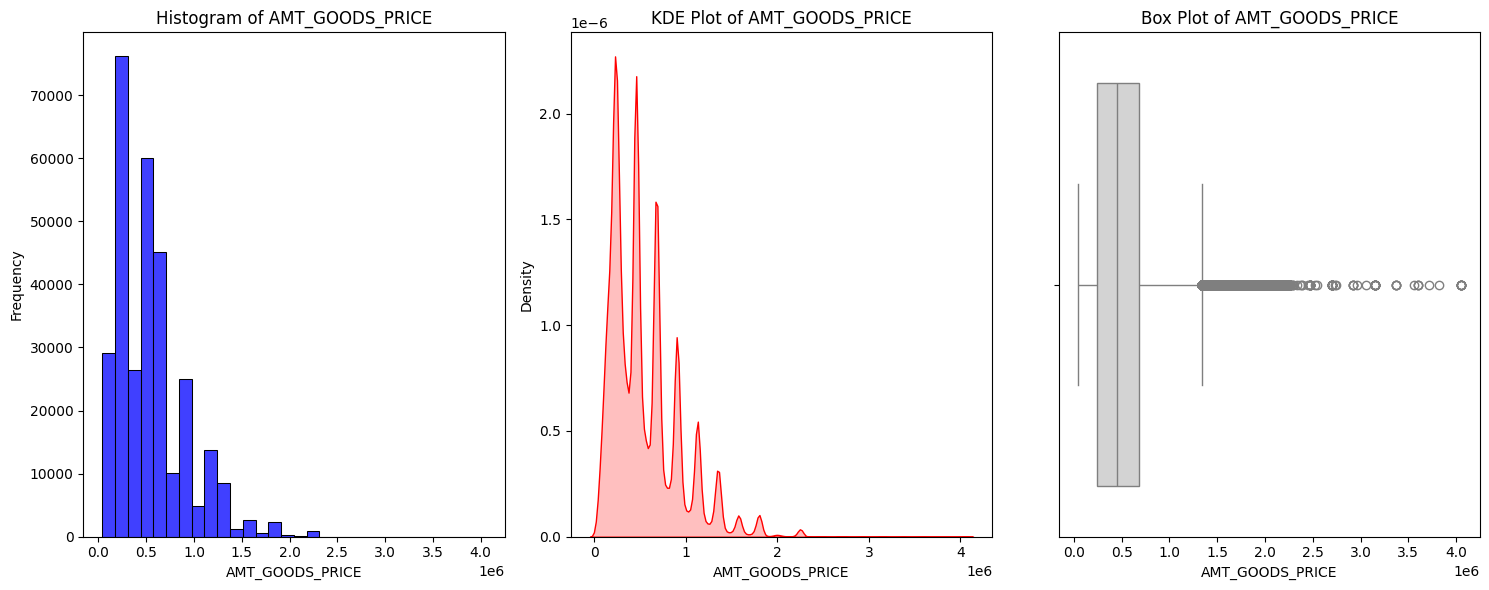

In [ ]:
# check for the distribution of the 2 variables
plot_distribution(appl_train_refined,'AMT_CREDIT')
plot_distribution(appl_train_refined,'AMT_GOODS_PRICE')

# I have decided to take the ratio of AMT_CREDIT to AMT_GOODS_PRICE as the merged variable

In [ ]:
# Merging and creating the variable RATIO_AMT_CREDIT_TO_GOODS_PRICE

# Impute null values in AMT_GOODS_PRICE with its median
median_goods_price = appl_train_3['AMT_GOODS_PRICE'].median()
appl_train_3['AMT_GOODS_PRICE'].fillna(median_goods_price, inplace=True)

# Calculate the ratio
appl_train_3['RATIO_AMT_CREDIT_TO_GOODS_PRICE'] = (
    appl_train_3['AMT_CREDIT'] / appl_train_3['AMT_GOODS_PRICE']
)

# Round the ratio to 2 decimal places
appl_train_3['RATIO_AMT_CREDIT_TO_GOODS_PRICE'] = (
    appl_train_3['RATIO_AMT_CREDIT_TO_GOODS_PRICE'].round(2)
)

appl_train_3.head(2)


<ipython-input-34-332679d3b631>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  appl_train_3['AMT_GOODS_PRICE'].fillna(median_goods_price, inplace=True)


,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,FLAG_EMP_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,...,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,NAME_CONTRACT_TYPE_encoded,CODE_GENDER_encoded,FLAG_OWN_CAR_encoded,NAME_INCOME_TYPE_encoded,NAME_EDUCATION_TYPE_encoded,NAME_FAMILY_STATUS_encoded,ORGANIZATION_TYPE_encoded,RATIO_AMT_CREDIT_TO_GOODS_PRICE
0,202500.0,406597.5,24700.5,351000.0,0.018801,-637.0,1.0,0.0,1.0,2.0,...,0.0,0.0,0.0,1.0,0.0,7.0,4.0,3.0,5.0,1.16
1,270000.0,1293502.5,35698.5,1129500.0,0.003541,-1188.0,1.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,39.0,1.15


Take care of the other 2 groups of features with collinearity problems


In [ ]:
# dropping columns FLOORSMAX_MODE, FLOORSMAX_MEDI and keeping only FLOORSMAX_AVG
# dropping column REGION_RATING_CLIENT
# dropping columns AMT_CREDIT and AMT_GOODS_PRICE

appl_train_4 = appl_train_3.drop(columns = ['AMT_CREDIT','AMT_GOODS_PRICE','FLOORSMAX_MODE','FLOORSMAX_MEDI','REGION_RATING_CLIENT'])
appl_train_4.head(2)

,AMT_INCOME_TOTAL,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,FLAG_EMP_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_WORK_REGION,...,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,NAME_CONTRACT_TYPE_encoded,CODE_GENDER_encoded,FLAG_OWN_CAR_encoded,NAME_INCOME_TYPE_encoded,NAME_EDUCATION_TYPE_encoded,NAME_FAMILY_STATUS_encoded,ORGANIZATION_TYPE_encoded,RATIO_AMT_CREDIT_TO_GOODS_PRICE
0,202500.0,24700.5,0.018801,-637.0,1.0,0.0,1.0,2.0,10.0,0.0,...,0.0,0.0,0.0,1.0,0.0,7.0,4.0,3.0,5.0,1.16
1,270000.0,35698.5,0.003541,-1188.0,1.0,0.0,2.0,1.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,39.0,1.15


### 4.6 Feature Scaling and Normalization for Imputation Model

Now that we have decided our final set of features, lets scale the columns - 'AMT_INCOME_TOTAL'

In [ ]:
mmscaler = MinMaxScaler()

# Scale the specified columns
appl_train_4[['AMT_INCOME_TOTAL']] = mmscaler.fit_transform(
    appl_train_4[['AMT_INCOME_TOTAL']]
)

appl_train_4.head(2)

,AMT_INCOME_TOTAL,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,FLAG_EMP_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_WORK_REGION,...,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,NAME_CONTRACT_TYPE_encoded,CODE_GENDER_encoded,FLAG_OWN_CAR_encoded,NAME_INCOME_TYPE_encoded,NAME_EDUCATION_TYPE_encoded,NAME_FAMILY_STATUS_encoded,ORGANIZATION_TYPE_encoded,RATIO_AMT_CREDIT_TO_GOODS_PRICE
0,0.001512,24700.5,0.018801,-637.0,1.0,0.0,1.0,2.0,10.0,0.0,...,0.0,0.0,0.0,1.0,0.0,7.0,4.0,3.0,5.0,1.16
1,0.002089,35698.5,0.003541,-1188.0,1.0,0.0,2.0,1.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,39.0,1.15


In [ ]:
# dealing with DAYS_EMPLOYED

# Make DAYS_EMPLOYED positive
appl_train_4['DAYS_EMPLOYED'] = appl_train_4['DAYS_EMPLOYED'].abs()
appl_train_4['DAYS_LAST_PHONE_CHANGE'] = appl_train_4['DAYS_LAST_PHONE_CHANGE'].abs()

#apply minmax scalar
appl_train_4['DAYS_EMPLOYED'] = mmscaler.fit_transform(appl_train_4[['DAYS_EMPLOYED']])
appl_train_4['DAYS_LAST_PHONE_CHANGE'] = mmscaler.fit_transform(appl_train_4[['DAYS_LAST_PHONE_CHANGE']])

appl_train_4.head(2)

,AMT_INCOME_TOTAL,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,FLAG_EMP_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_WORK_REGION,...,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,NAME_CONTRACT_TYPE_encoded,CODE_GENDER_encoded,FLAG_OWN_CAR_encoded,NAME_INCOME_TYPE_encoded,NAME_EDUCATION_TYPE_encoded,NAME_FAMILY_STATUS_encoded,ORGANIZATION_TYPE_encoded,RATIO_AMT_CREDIT_TO_GOODS_PRICE
0,0.001512,24700.5,0.018801,0.001744,1.0,0.0,1.0,2.0,10.0,0.0,...,0.0,0.0,0.0,1.0,0.0,7.0,4.0,3.0,5.0,1.16
1,0.002089,35698.5,0.003541,0.003253,1.0,0.0,2.0,1.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,39.0,1.15


In [ ]:
# Dropping the rows where AMT_ANNUITY is null and storing them in a separate df

final_rows_for_imputation = appl_train_4[appl_train_3['AMT_ANNUITY'].isnull()]
appl_train_4 = appl_train_4.dropna(subset=['AMT_ANNUITY'])

In [ ]:
final_rows_for_imputation

,AMT_INCOME_TOTAL,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,FLAG_EMP_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_WORK_REGION,...,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,NAME_CONTRACT_TYPE_encoded,CODE_GENDER_encoded,FLAG_OWN_CAR_encoded,NAME_INCOME_TYPE_encoded,NAME_EDUCATION_TYPE_encoded,NAME_FAMILY_STATUS_encoded,ORGANIZATION_TYPE_encoded,RATIO_AMT_CREDIT_TO_GOODS_PRICE
47531,0.001320,NaN,0.026392,0.006908,1.0,0.0,1.0,2.0,13.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,2.0,3.0,5.0,1.00
50035,0.000589,NaN,0.035792,0.003477,1.0,0.0,2.0,2.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.0,3.0,0.0,3.0,1.00
51594,0.001512,NaN,0.046220,0.010815,1.0,0.0,2.0,1.0,15.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.0,4.0,1.0,42.0,1.20
55025,0.001166,NaN,0.035792,0.005585,1.0,0.0,2.0,2.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,11.0,1.32
59934,0.001512,NaN,0.046220,0.006839,1.0,0.0,1.0,1.0,15.0,1.0,...,0.0,1.0,0.0,1.0,1.0,7.0,4.0,3.0,33.0,1.00
75873,0.001012,NaN,0.022800,0.006708,1.0,0.0,1.0,2.0,15.0,0.0,...,0.0,0.0,0.0,1.0,1.0,7.0,1.0,3.0,5.0,1.32
89343,0.000550,NaN,0.015221,0.010188,1.0,0.0,2.0,2.0,11.0,0.0,...,0.0,0.0,0.0,0.0,1.0,4.0,4.0,1.0,30.0,1.00
123872,0.001512,NaN,0.019689,0.009692,1.0,1.0,2.0,2.0,12.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.0,4.0,0.0,42.0,1.29
207186,0.001243,NaN,0.018634,0.001292,1.0,0.0,2.0,2.0,13.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,40.0,1.00
227939,0.002474,NaN,0.046220,0.004047,1.0,0.0,2.0,1.0,11.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,1.26


In [ ]:
# converting the dataframe to numpy arrays
X = np.array(appl_train_4.drop('AMT_ANNUITY', axis=1))
y = np.array(appl_train_4['AMT_ANNUITY'])

In [ ]:
print(X[0:3,:])
print(X.shape)

[[1.51186991e-03 1.88010000e-02 1.74404438e-03 1.00000000e+00
  0.00000000e+00 1.00000000e+00 2.00000000e+00 1.00000000e+01
  0.00000000e+00 0.00000000e+00 2.62948593e-01 8.33000000e-02
  1.49000000e-02 2.64212488e-01 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  7.00000000e+00 4.00000000e+00 3.00000000e+00 5.00000000e+00
  1.16000000e+00]
 [2.08891949e-03 3.54100000e-03 3.25262907e-03 1.00000000e+00
  0.00000000e+00 2.00000000e+00 1.00000000e+00 1.10000000e+01
  0.00000000e+00 0.00000000e+00 6.22245775e-01 2.91700000e-01
  7.14000000e-02 1.92917055e-01 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.00000000e+00 1.00000000e+00 1.00000000e+00 3.90000000e+01
  1.15000000e+00]
 [3.57770742e-04 1.00320000e-02 6.16028233e-04 1.00000000e+00
  0.00000000e+00 1.00000000e+00 2.00000000e+00 9.00000000e+00
  0.00000000e+00 0.00000000e+00 5.55912083e-01            nan
             nan 1.89888164e-01 0.

In [ ]:
print(y[0:3,])
print(y.shape)

[24700.5 35698.5  6750. ]
(307499,)


In [ ]:

# Train-test split (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

print("Training Features:\n", X_train.shape)
print("Training Target:\n", y_train.shape)
print("Testing Features:\n", X_test.shape)
print("Testing Target:\n", y_test.shape)

Training Features:
 (245999, 25)
Training Target:
 (245999,)
Testing Features:
 (61500, 25)
Testing Target:
 (61500,)


## 4.7 LIGHTGBM Model Training with 5 fold cross validation

I plan on training the data in the following way

- As you can see I have already separated 20% data for testing.
- Now the train data (i.e 80%) will be under go the 5 fold cross validation process
- Then we can get the best RMSE (my evaluation metric for this moodel) for 5 fold cross validation process
- Finally we will build the model on the whole training data and make the

In [ ]:
# Create LightGBM dataset
train_data = lgbm.Dataset(X_train, label=y_train)
test_data = lgbm.Dataset(X_test, label=y_test, reference=train_data)

In [ ]:
# Set parameters for the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.03,
    'num_leaves': 30,
    'verbose': 1
}

# Perform K-Fold Cross-Validation
cv_results = lgbm.cv(
    params,
    train_data,
    num_boost_round=1000,       # Number of boosting rounds
    nfold=5,                   # Number of folds
    metrics='rmse',            # Evaluation metric
    stratified=False
)

cv_score = min(cv_results['valid rmse-mean'])

# Print the CV score
print("CV RMSE Score: ", cv_score)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1654
[LightGBM] [Info] Number of data points in the train set: 196796, number of used features: 25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1654
[LightGBM] [Info] Number of data points in the train set: 196796, number of used features: 25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1654
[LightGBM] [Info] Number of data

In [ ]:
# Print cross-validation results
print("Best RMSE: ", min(cv_results['valid rmse-mean']))

Best RMSE:  10107.937051493398


In [ ]:
# Train the model with early stopping and optimal num boost rounds that we got from 5 fold cv

lgbm_model = lgbm.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[test_data]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1654
[LightGBM] [Info] Number of data points in the train set: 245999, number of used features: 25
[LightGBM] [Info] Start training from score 27120.115110


In [ ]:
# Predict on the test set
y_pred = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Test RMSE: ", rmse)

Test RMSE:  10117.617427842439


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


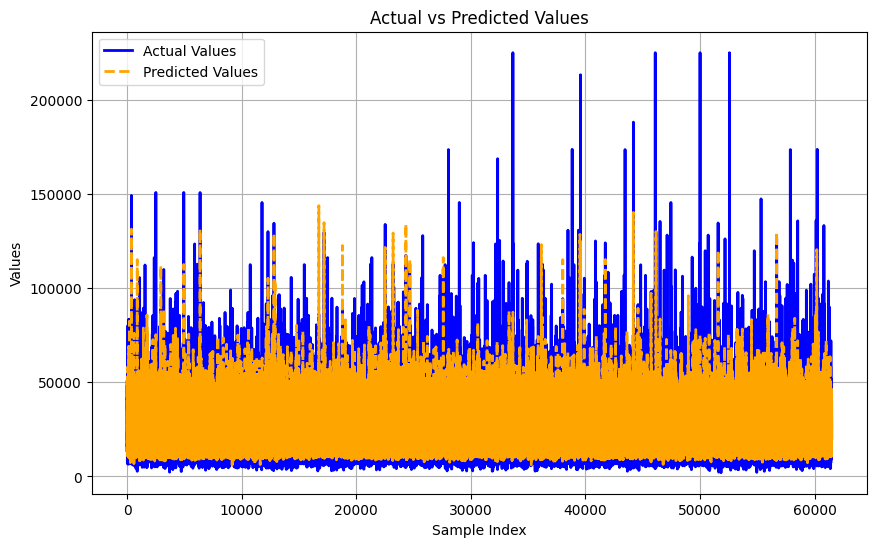

In [ ]:
# Convert y_test and y_pred to pandas Series
y_test_series = pd.Series(y_test).reset_index(drop=True)
y_pred_series = pd.Series(y_pred)

# Line Plot for Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_series, label='Actual Values', color='blue', linewidth=2)
plt.plot(y_pred_series, label='Predicted Values', color='orange', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Now using the above model to impute the 12 missing values

X_missing = np.array(final_rows_for_imputation.drop('AMT_ANNUITY', axis=1))
y_missing = np.array(final_rows_for_imputation['AMT_ANNUITY'])

In [ ]:
# predict missing values
y_pred_missing = lgbm_model.predict(X_missing, num_iteration=lgbm_model.best_iteration)

In [ ]:
y_pred_missing

array([25772.46449965, 21599.84301145, 29199.5341337 , 26290.14381451,
       30433.70880488, 22291.982206  , 22188.38300024, 35438.11132234,
       27516.3155974 , 29800.85762735, 29278.1063208 , 55642.9651374 ])

Now we can use the imputed values in the training of the main model for credit risk default prediction

# 4.7 Imputation of other variables by Different Method

Here instead of building imputation models, we have opted for an analytical ruled based approach where we will impute the missing columns based on the most appropriate central tendancy metric.

In [ ]:
##Imputation Function from starting to end
# Check Missing Values
def check_missing_values_p(df: pd.DataFrame, column_name: str) -> int:
    """
    Function to count missing values (NaN) in a specified column in a Pandas DataFrame.

    Parameters:
        df : pd.DataFrame
            The input Pandas DataFrame.
        column_name : str
            The name of the column to check for missing values.

    Returns:
        int: Number of missing values in the column.
    """
    missing_values = df[column_name].isna().sum()
    print(f"Missing values in {column_name}: {missing_values}")
    return missing_values

# Check Distribution of Column
def check_distribution_p(df: pd.DataFrame, column_name: str) -> dict:
    """
    Function to display basic statistics (mean, stddev, min, max) of a specified column in a Pandas DataFrame.

    Parameters:
        df : pd.DataFrame
            The input Pandas DataFrame.
        column_name : str
            The name of the column to check the distribution.

    Returns:
        dict: A dictionary containing count, mean, stddev, min, and max values.
    """
    summary = df[column_name].describe()
    summary_dict = {
        'count': summary['count'],
        'mean': summary['mean'],
        'stddev': summary['std'] if 'std' in summary.index else None,
        'min': summary['min'],
        'max': summary['max']
    }

    print(summary_dict)
    return summary_dict

# Choose Imputation Method
def choose_imputation_method_p(count, mean, stddev, min_val, max_val) -> str:
    """
    Function to suggest the best imputation method (mean, median, or mode)
    based on the summary statistics of a column.

    Parameters:
        count (int): Total count of non-null values in the column.
        mean (float): Mean of the column values.
        stddev (float): Standard deviation of the column values.
        min_val (float): Minimum value in the column.
        max_val (float): Maximum value in the column.

    Returns:
        str: Recommended imputation method ('mean', 'median', or 'mode').
    """
    # If there's a small standard deviation, mean imputation is okay
    if stddev <= mean:
        return "mean"

    # If standard deviation is high, there's likely more variation or outliers
    if stddev > mean:
        # Mode is useful if the minimum value is 0 and data is skewed (potentially binary or categorical)
        if min_val == 0 and max_val / mean > 5:
            return "mode"
        else:
            return "median"

    # Default to median if no strong preference can be inferred
    return "median"


# Impute Missing Values with Mean, Median, Mode
def impute_method_p(df: pd.DataFrame, column_name: str, method: str) -> pd.DataFrame:
    """
    Function to impute missing values in a column with the specified method (mean, median, mode).

    Parameters:
        df : pd.DataFrame
            The input Pandas DataFrame.
        column_name : str
            The name of the column to impute missing values for.
        method : str
            The imputation method ('mean', 'median', 'mode').

    Returns:
        pd.DataFrame: DataFrame with missing values imputed.
    """
    if method == 'mean':
        mean_value = df[column_name].mean()
        print(f"Mean for {column_name}: {mean_value}")
        df[column_name].fillna(mean_value, inplace=True)

    elif method == 'median':
        median_value = df[column_name].median()
        print(f"Median for {column_name}: {median_value}")
        df[column_name].fillna(median_value, inplace=True)

    elif method == 'mode':
        mode_value = df[column_name].mode()[0]
        print(f"Mode for {column_name}: {mode_value}")
        df[column_name].fillna(mode_value, inplace=True)

    else:
        print("Invalid method")

    return df

# Verify Imputation
def verify_imputation_p(df: pd.DataFrame, column_name: str) -> int:
    """
    Function to verify if all missing values in a column have been imputed.

    Parameters:
        df : pd.DataFrame
            The input Pandas DataFrame.
        column_name : str
            The name of the column to verify imputation for.

    Returns:
        int: Number of remaining missing values.
    """
    missing_values = df[column_name].isna().sum()
    print(f"Remaining missing values in {column_name}: {missing_values}")
    return missing_values


In [ ]:
column='DEF_30_CNT_SOCIAL_CIRCLE'

In [ ]:
missing_count = check_missing_values_p(appl_train, column)

Missing values in DEF_30_CNT_SOCIAL_CIRCLE: 1021


In [ ]:
summary_stats = check_distribution_p(appl_train,column)

{'count': 306490.0, 'mean': 0.1434206662533851, 'stddev': 0.4466984293825373, 'min': 0.0, 'max': 34.0}


In [ ]:
# Choose imputation method
method = choose_imputation_method_p(
    count=summary_stats['count'],
    mean=summary_stats['mean'],
    stddev=summary_stats['stddev'],
    min_val=summary_stats['min'],
    max_val=summary_stats['max']
)
print(method)

mode


In [ ]:
appl_train = impute_method_p(appl_train, column, method)

Mode for DEF_30_CNT_SOCIAL_CIRCLE: 0.0


<ipython-input-53-4011cf5ba0bd>:107: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].fillna(mode_value, inplace=True)


In [ ]:
verify_imputation_p(appl_train, column)

Remaining missing values in DEF_30_CNT_SOCIAL_CIRCLE: 0


0

In [ ]:
summary_stats = check_distribution_p(appl_train, column)

{'count': 307511.0, 'mean': 0.14294448003486054, 'stddev': 0.4460325557437661, 'min': 0.0, 'max': 34.0}


# 5. Exploratory Data Analysis (for Application_Train file after cleaning)
There are 10 files in our library: 7 of them are data sources, and the remaining 3 are the train, test, and sample submission files. We'll check on the main file first (application_train.csv) and see what we can make out of it, then use the test set (application_test.csv) to make our submission.


In [ ]:
appl_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [ ]:
appl_train.shape

(307511, 122)

* For the training file, we have a total of **307511 observations** and **122 features** to consider -- with integer, float and object datatypes, and 67 features having null values.

* The test file is almost similar: having **48744 observations**, **121 features** (minus the predictor variable 'TARGET'), and 64 features having null values.


Note on the words being used:

* **observations** == samples == rows
* **features** == fields == columns
* **defaulted** == failed to meet the legal obligations of the loan

In [ ]:
# Print first 5 rows of the training file
appl_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Since our model is to classify the 'target' column, we can plot it to visualize the current sample distribution.

TARGET
0    282686
1     24825
Name: count, dtype: int64


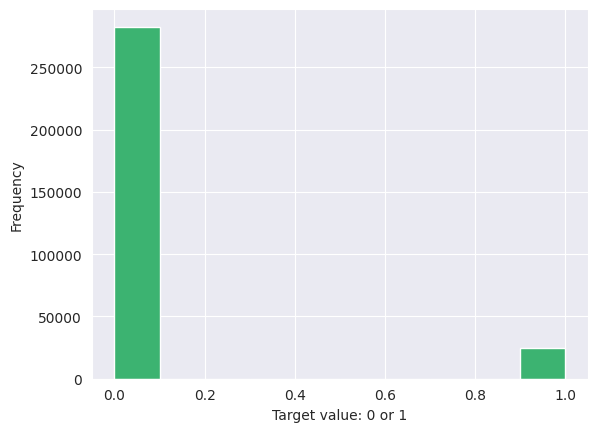

In [ ]:
# Show target distribution
sns.set_style('darkgrid')
print(appl_train.TARGET.value_counts())
appl_train.TARGET.plot.hist(color='mediumseagreen').set_xlabel('Target value: 0 or 1');

Base on the above information, the dataset is **imbalanced**. Only around 8% of the training set aren't repaid.



JUST TO BE CLEAR, OUR INDICATOR ON WHETHER A CURRENT/ PREVIOUS CUSTOMER DEFAULTED ON A LOAN CAN BE SEEN AT 'TARGET' COLUMN:

**TARGET == 0 --> individuals who paid their loan**

**TARGET == 1 --> individuals who did NOT repay their loan**

Now, let's take a closer look on the fields.

# 5.1 Analyzing Data Insights (EDA)

We'll be taking note of the things below during our field inspection:

1. **Completing** - any missing values to fill in?
2. **Correlation** - which features contribute significantly to our solution goal?
3. **Correcting** - any outlier that skews our data terribly? Do we have some unusual error seen on the dataset? We may need to correct or exclude inaccurate features.
4. **Conversion** - most of the time, the text features need to be converted to numerical values for our model training.
5. **Creating** - maybe we can create a new feature out of the existing set of highly correlated features?

Before anything else, it's important to understand why these fields are recorded in the first place. And below is my understanding on how do we know if an applicant is a good candidate for a loan application.
![home_credit.jpg](https://upload.wikimedia.org/wikipedia/commons/c/cb/Home-Credit-logo.jpg)

(I'm not claiming that this is right, but for me, this makes sense.)

During field inspection, I'll try to comprehend whether a certain field falls on any of these questions. It can serve as a guide on how we deal with a certain feature. Below are excel sheet snippets of the initial sorting that I made on all the fields (please see TAG column).

Decisions:
* 'SK_ID_CURR' is just the loan ID which is unique for every individual. It will not contribute to the prediction algorithm. --> DROP
* The 'TARGET' variable is the one that we are trying to predict, so we will NOT use it as a feature.

In [ ]:
# COLUMNS TO BE DROPPED
list_col_drop = ['SK_ID_CURR']

In [ ]:
tempY=appl_train[appl_train.FLAG_OWN_CAR=='Y']
tempN=appl_train[appl_train.FLAG_OWN_CAR=='N']
tempY_targ1=tempY[tempY.TARGET==1]
tempN_targ1=tempN[tempN.TARGET==1]

In [ ]:
print('People count who owns a car:',len(tempY),'(',round(len(tempY)/len(appl_train.index)*100,2),'%)')
print('People count who DOES NOT own a car:',len(tempN),'(',round(len(tempN)/len(appl_train.index)*100,2),'%)')
print('Percentage of people who defaulted (with cars):',round(len(tempY_targ1)/len(tempY)*100,2),'%')
print('Percentage of people who defaulted (no cars):',round(len(tempN_targ1)/len(tempN)*100,2),'%')

People count who owns a car: 104587 ( 34.01 %)
People count who DOES NOT own a car: 202924 ( 65.99 %)
Percentage of people who defaulted (with cars): 7.24 %
Percentage of people who defaulted (no cars): 8.5 %


In [ ]:
tempY=appl_train[appl_train.FLAG_OWN_REALTY=='Y']
tempN=appl_train[appl_train.FLAG_OWN_REALTY=='N']
tempY_targ1=tempY[tempY.TARGET==1]
tempN_targ1=tempN[tempN.TARGET==1]

Observations:
* It's a small difference but it looks like people with no car and/or realty tend to default more than those who have.

Decisions:
* I'll be converting these 2 categorical fields into one nominal field called 'assets'.

In [ ]:
# CREATE NEW COLUMN : 0 - none, 1 - with car no realty, 2 - no car with realty, 3 - with car with realty
list_col_new_asset = ['FLAG_OWN_CAR','FLAG_OWN_REALTY']

The expenditure-related set is quite a lot. We can break it down base on the fields' relatedness.

Expenditure-related: THE LOAN ITSELF.

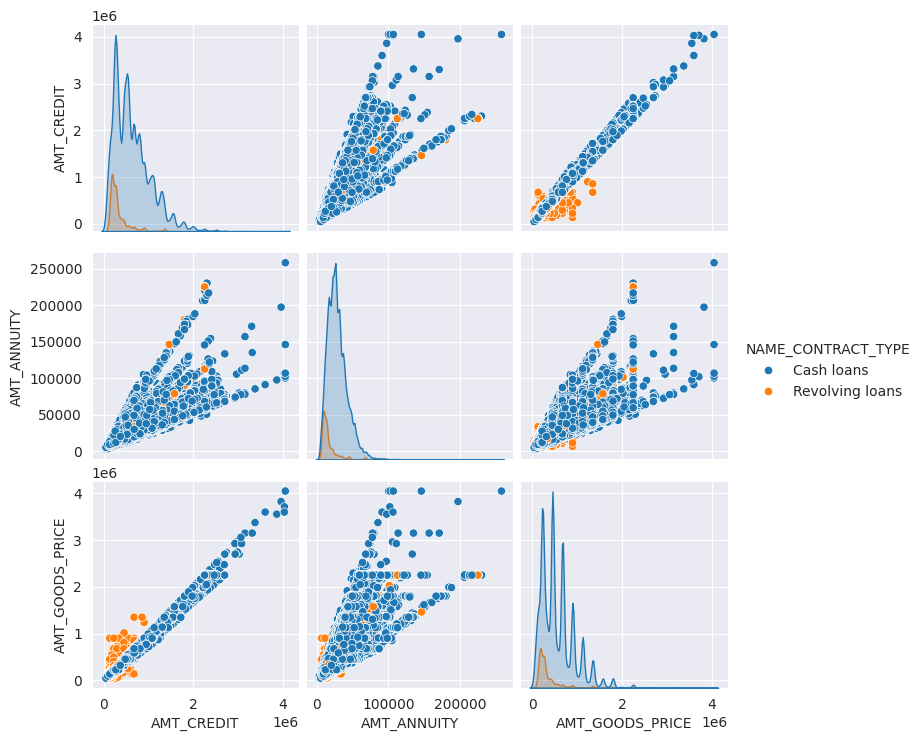

In [ ]:
sns.pairplot(appl_train[['NAME_CONTRACT_TYPE','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']],hue='NAME_CONTRACT_TYPE');

In [ ]:
corr1=round(appl_train.AMT_CREDIT.corr(appl_train.AMT_GOODS_PRICE),2)
corr2=round(appl_train.AMT_ANNUITY.corr(appl_train.AMT_CREDIT),2)
corr3=round(appl_train.AMT_ANNUITY.corr(appl_train.AMT_GOODS_PRICE),2)

In [ ]:
print('Correlation of Credit amount vs Price of goods:',corr1)
print('Correlation of Annuity amount vs Credit amount:',corr2)
print('Correlation of Annuity amount vs Price of goods:',corr3)

Correlation of Credit amount vs Price of goods: 0.99
Correlation of Annuity amount vs Credit amount: 0.77
Correlation of Annuity amount vs Price of goods: 0.78


In [ ]:
cash=appl_train[appl_train.NAME_CONTRACT_TYPE == 'Cash loans']
rev=appl_train[appl_train.NAME_CONTRACT_TYPE == 'Revolving loans']
def_cash=cash[cash.TARGET==1]
def_rev=rev[rev.TARGET==1]

Percentage of defaulted cash loan: 8.35 %
Percentage of defaulted revolving loan: 5.48 %


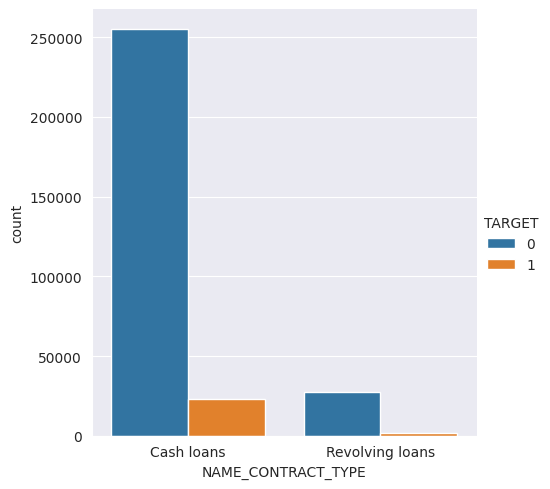

In [ ]:
print('Percentage of defaulted cash loan:',round(len(def_cash)/len(cash)*100,2,),'%')
print('Percentage of defaulted revolving loan:',round(len(def_rev)/len(rev)*100,2),'%')
sns.catplot(data=appl_train,x='NAME_CONTRACT_TYPE',hue='TARGET',kind='count');

Observations:
* AMT_CREDIT and AMT_GOODS_PRICE are highly correlated (scoring 0.99!), and has a positive linear slope - which makes sense because as the price of goods for which the loan is given gets higher, the credit amount of the loan (ofcourse) gets higher too.
* AMT_ANNUITY is also highly correlated to AMT_CREDIT and AMT_GOODS_PRICE with a positive linearity. It's because the annuity is the monthly due amount.
* NAME_CONTRACT_TYPE: Accounting for those who defaulted is much bigger in terms of cash loan than those with revolving loan, however, we must note that cash loan is *significantly* more popular to our sample consumers than the other.

Decisions:
* AMT_GOODS_PRICE - to drop as it is quite redundant. We already have the AMT_CREDIT field to account for the loan amount.
* AMT_ANNUITY - create new feature PERCENT_ANNUITY_INCOME to indicate the loan annuity amount relative to the person's total income.
* AMT_CREDIT - create new feature PERCENT_CREDIT_INCOME to indicate the loan credit amount relative to the person's total income.
* NAME_CONTRACT_TYPE - to drop since the defaulting rate for both loan type has less than 3% difference. We can focus more on the person's percentage of annuity or credit amount relative to their income.

In [ ]:
# COLUMNS TO BE DROPPED
list_col_drop.extend(['NAME_CONTRACT_TYPE','AMT_GOODS_PRICE'])

# CREATE NEW COLUMN : PERCENT_ANNUITY_INCOME
list_col_new_annuity = ['AMT_ANNUITY','AMT_INCOME_TOTAL']

# CREATE NEW COLUMN : CREDIT_ANNUITY_INCOME
list_col_new_credit = ['AMT_CREDIT','AMT_INCOME_TOTAL']

Expenditure-related: SIZE OF HOUSEHOLD

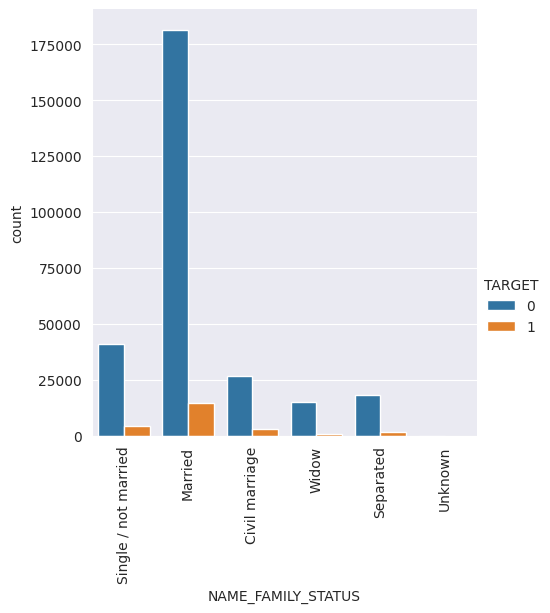

In [ ]:
sns.catplot(data=appl_train,x='NAME_FAMILY_STATUS',hue='TARGET',kind='count');
plt.xticks(rotation=90);

In [ ]:
appl_train[['CNT_CHILDREN','NAME_FAMILY_STATUS','CNT_FAM_MEMBERS']][appl_train.NAME_FAMILY_STATUS=='Married'].tail()

,CNT_CHILDREN,NAME_FAMILY_STATUS,CNT_FAM_MEMBERS
307500,0,Married,2.0
307501,3,Married,5.0
307502,1,Married,3.0
307509,0,Married,2.0
307510,0,Married,2.0


Observations:
* We have a large number of married customers in our sample population. The married set also contains the most frequent defaulting individuals.
* 'CNT_CHILDREN', 'NAME_FAMILY_STATUS', 'CNT_FAM_MEMBERS' are all related to family size. And if we only want to consider the family size for approximation of expenditures, we already have 'CNT_FAM_MEMBERS' wherein it accounts for the customer itself, plus spouse (if any), plus number of children (if any).

Decisions:
* Use 'CNT_FAM_MEMBER' as a feature model. Fill in missing values.
* Drop 'CNT_CHILDREN' and 'NAME_FAMILY_STATUS'.

In [ ]:
# COLUMNS TO BE DROPPED
list_col_drop.extend(['CNT_CHILDREN', 'NAME_FAMILY_STATUS'])

# COMPLETE COLUMN :
list_col_fill_fam = ['CNT_FAM_MEMBERS']

Expenditure-related: TRAVEL

In [ ]:
corr1=round(appl_train.OWN_CAR_AGE.corr(appl_train.TARGET),2)
corr2=round(appl_train.REG_REGION_NOT_WORK_REGION.corr(appl_train.TARGET),2)
corr3=round(appl_train.REG_CITY_NOT_WORK_CITY.corr(appl_train.TARGET),2)
no_car,yes_car = appl_train.FLAG_OWN_CAR.value_counts()

In [ ]:
print('Correlation of Age of Car vs Target:',corr1)
print('Correlation of Registered Region aint Work Region vs Target:',corr2)
print('Correlation of Registered City aint Work City vs Target:',corr3)

Correlation of Age of Car vs Target: 0.04
Correlation of Registered Region aint Work Region vs Target: 0.01
Correlation of Registered City aint Work City vs Target: 0.05


In [ ]:
appl_train[['OWN_CAR_AGE','REG_REGION_NOT_WORK_REGION','REG_CITY_NOT_WORK_CITY']].describe()

,OWN_CAR_AGE,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_WORK_CITY
count,104582.000000,307511.000000,307511.000000
mean,12.061091,0.050769,0.230454
std,11.944812,0.219526,0.421124
min,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000
50%,9.000000,0.000000,0.000000
75%,15.000000,0.000000,0.000000
max,91.000000,1.000000,1.000000


In [ ]:
print('How many customers own a car? :',yes_car)
print('How many customers do NOT own a car? :',no_car)
print('How many missing values on OWN_CAR_AGE? :',appl_train.OWN_CAR_AGE.isnull().sum())

How many customers own a car? : 104587
How many customers do NOT own a car? : 202924
How many missing values on OWN_CAR_AGE? : 202929


Observations:
* We have a low correlation between these travel-related fields and the target variable.
* The number of missing values on 'OWN_CAR_AGE' is almost == number of customers who do NOT own a car -- which CAUSES the field to have missing values.

Decisions:
* Drop REG_REGION_NOT_WORK_REGION and REG_CITY_NOT_WORK_CITY as there is low correlation wrt TARGET variable.
* Create new ordinal category 'Car Expenditure' from a continuous numerical feature 'OWN_CAR_AGE'. Perhaps the older the car, the higher the maintenance expenditure.

In [ ]:
# CREATE NEW COLUMN : EXPENDITURE_CAR : 0 - no car, +=1 per age band
list_col_new_car = ['OWN_CAR_AGE']

# COLUMNS TO BE DROPPED
list_col_drop.extend(['REG_REGION_NOT_WORK_REGION','REG_CITY_NOT_WORK_CITY'])

Expenditure-related: RESIDENCE

In [ ]:
temp = ['NAME_HOUSING_TYPE',
        'APARTMENTS_AVG',
        'BASEMENTAREA_AVG',
        'YEARS_BEGINEXPLUATATION_AVG',
        'YEARS_BUILD_AVG',
        'COMMONAREA_AVG',
        'ELEVATORS_AVG',
        'ENTRANCES_AVG',
        'FLOORSMAX_AVG',
        'FLOORSMIN_AVG',
        'LANDAREA_AVG',
        'LIVINGAPARTMENTS_AVG',
        'LIVINGAREA_AVG',
        'NONLIVINGAPARTMENTS_AVG',
        'NONLIVINGAREA_AVG',
        'APARTMENTS_MODE',
        'BASEMENTAREA_MODE',
        'YEARS_BEGINEXPLUATATION_MODE',
        'YEARS_BUILD_MODE',
        'COMMONAREA_MODE',
        'ELEVATORS_MODE',
        'ENTRANCES_MODE',
        'FLOORSMAX_MODE',
        'FLOORSMIN_MODE',
        'LANDAREA_MODE',
        'LIVINGAPARTMENTS_MODE',
        'LIVINGAREA_MODE',
        'NONLIVINGAPARTMENTS_MODE',
        'NONLIVINGAREA_MODE',
        'APARTMENTS_MEDI',
        'BASEMENTAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MEDI',
        'YEARS_BUILD_MEDI',
        'COMMONAREA_MEDI',
        'ELEVATORS_MEDI',
        'ENTRANCES_MEDI',
        'FLOORSMAX_MEDI',
        'FLOORSMIN_MEDI',
        'LANDAREA_MEDI',
        'LIVINGAPARTMENTS_MEDI',
        'LIVINGAREA_MEDI',
        'NONLIVINGAPARTMENTS_MEDI',
        'NONLIVINGAREA_MEDI',
        'FONDKAPREMONT_MODE',
        'HOUSETYPE_MODE',
        'TOTALAREA_MODE',
        'WALLSMATERIAL_MODE',
        'EMERGENCYSTATE_MODE']

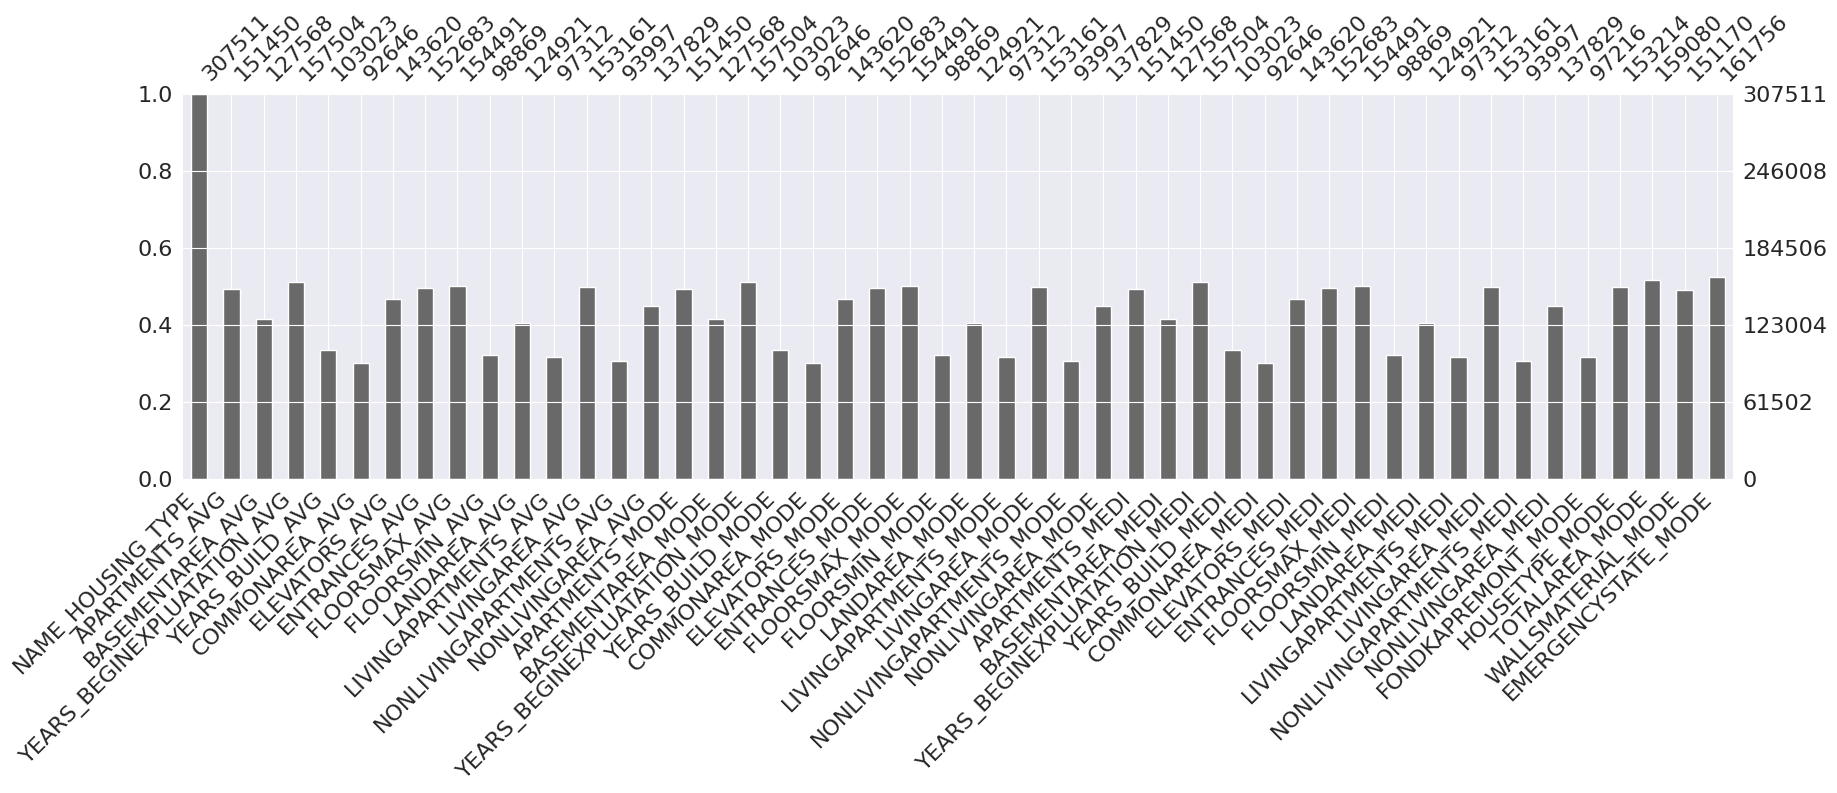

In [ ]:
# Nullity by column
msno.bar(appl_train[temp],figsize=(20,5));

In [ ]:
# Identify non-numeric columns
non_numeric_columns = appl_train.select_dtypes(include=['object']).columns
print("Categorical Columns:", non_numeric_columns)


Categorical Columns: Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')


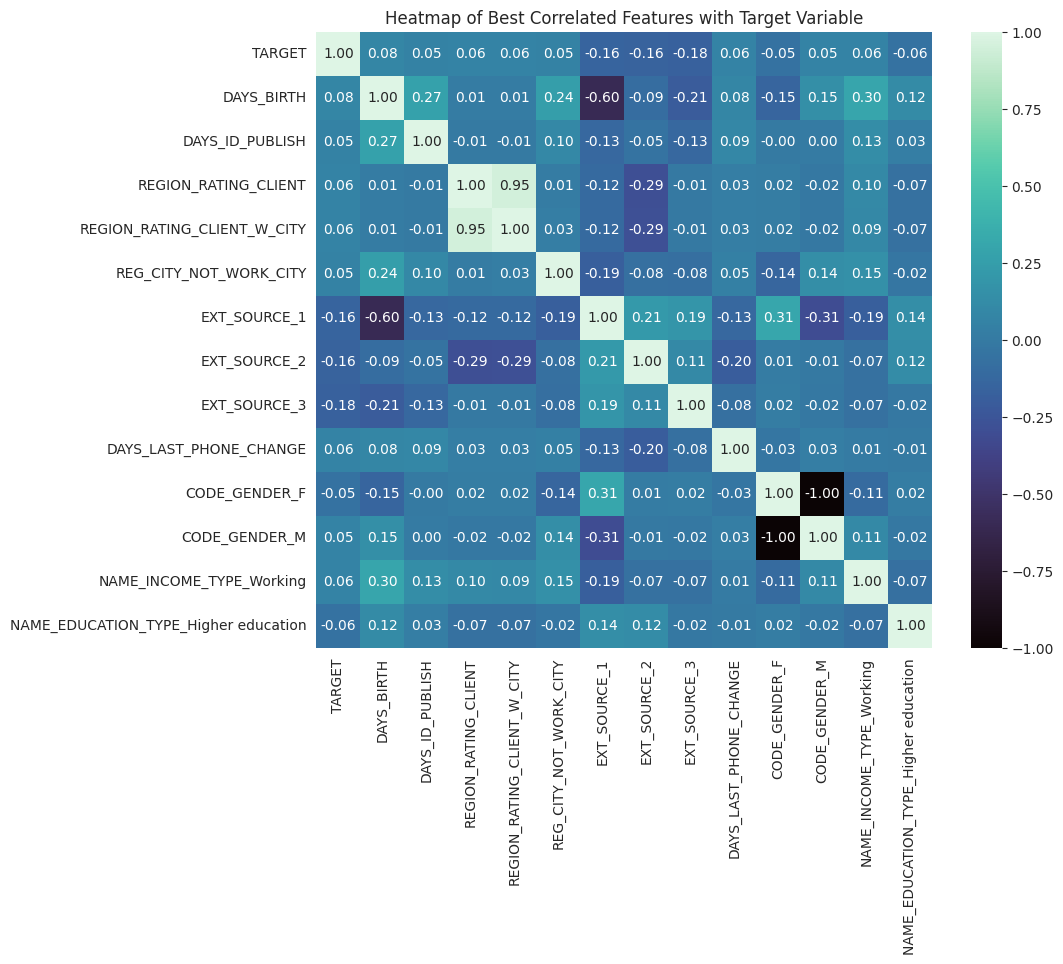

In [ ]:
# One-hot encode categorical columns

appl_train = pd.get_dummies(appl_train, columns=non_numeric_columns, drop_first=False)# trurned to false for the timing for visualization and hypothesis testing

# Calculate the correlation matrix
correlations = appl_train.corr()

# Set a threshold for selecting strong correlations
threshold = 0.05

# Select features with correlations above the threshold with the target
best_features = correlations['TARGET'][abs(correlations['TARGET']) > threshold].index

# Create a subset of the correlation matrix with these features and the target
best_corr_matrix = correlations.loc[best_features, best_features]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(best_corr_matrix, annot=True, cmap='mako', vmin=-1, vmax=1, fmt=".2f", square=True)
plt.title("Heatmap of Best Correlated Features with Target Variable")
plt.show()

This heatmap above shows the correlation of those fields with null values: how strongly the presence or absence of one variable affects the presence of another.

* 1 : positive correlation (blue) >> if a variable appears, the other variable definitely does too.
* 0 : zero correlation (white) >> variables appearing or not appearing have no effect on one another.
* -1 : negative correlation (red) >> if a variable appears, the other variable definitely does NOT.


In [ ]:
appl_train.columns.to_list()

['SK_ID_CURR',
 'TARGET',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAR

In [ ]:
# for i in ['APARTMENTS_AVG','LANDAREA_AVG','LIVINGAPARTMENTS_AVG','NONLIVINGAREA_MEDI']:
#     temp=appl_train[['NAME_HOUSING_TYPE']][appl_train[i].isnull()]
#     sns.catplot(data=temp,x='NAME_HOUSING_TYPE',kind='count',palette="rocket")
#     plt.xticks(rotation=20)
#     title = 'Housing Types with null values on ' + i
#     plt.title(title)

Observations:
* Every unit/size-related field starting from 'APARTMENTS_AVG' till 'WALLSMATERIAL_MODE' are highly correlated with each other, with no value less than 0.7.
* I've plotted 4 sample features of these normalized information on where the customer lives, and it seems that the missing values are mostly coming from 'houses/apartments' -- take note, the 'rented' apartment is a different type (with it having a low count of missing values). Come to think of it, if we are living in a house for so long, we usually don't bother knowing its floor size or maybe we've forgotten about it - which is very much understandable. (unless you are going to renovate, rent-out or sell the place!)
* The housing type that scored second highest with null values is 'with parents', and again it is common that someone living with parents won't actually bother knowing the land and floor area of their current residence. (from where I come from, this is usually the case)

Decisions:
* Since these are all residence-related sizes, I will consolidate them into one field to account for 'house expenditures'.

In [ ]:
# CREATE NEW COLUMN : EXPENDITURE_HOUSE
list_col_new_house = ['NAME_HOUSING_TYPE',
                    'APARTMENTS_AVG',
                    'BASEMENTAREA_AVG',
                    'YEARS_BEGINEXPLUATATION_AVG',
                    'YEARS_BUILD_AVG',
                    'COMMONAREA_AVG',
                    'ELEVATORS_AVG',
                    'ENTRANCES_AVG',
                    'FLOORSMAX_AVG',
                    'FLOORSMIN_AVG',
                    'LANDAREA_AVG',
                    'LIVINGAPARTMENTS_AVG',
                    'LIVINGAREA_AVG',
                    'NONLIVINGAPARTMENTS_AVG',
                    'NONLIVINGAREA_AVG',
                    'APARTMENTS_MODE',
                    'BASEMENTAREA_MODE',
                    'YEARS_BEGINEXPLUATATION_MODE',
                    'YEARS_BUILD_MODE',
                    'COMMONAREA_MODE',
                    'ELEVATORS_MODE',
                    'ENTRANCES_MODE',
                    'FLOORSMAX_MODE',
                    'FLOORSMIN_MODE',
                    'LANDAREA_MODE',
                    'LIVINGAPARTMENTS_MODE',
                    'LIVINGAREA_MODE',
                    'NONLIVINGAPARTMENTS_MODE',
                    'NONLIVINGAREA_MODE',
                    'APARTMENTS_MEDI',
                    'BASEMENTAREA_MEDI',
                    'YEARS_BEGINEXPLUATATION_MEDI',
                    'YEARS_BUILD_MEDI',
                    'COMMONAREA_MEDI',
                    'ELEVATORS_MEDI',
                    'ENTRANCES_MEDI',
                    'FLOORSMAX_MEDI',
                    'FLOORSMIN_MEDI',
                    'LANDAREA_MEDI',
                    'LIVINGAPARTMENTS_MEDI',
                    'LIVINGAREA_MEDI',
                    'NONLIVINGAPARTMENTS_MEDI',
                    'NONLIVINGAREA_MEDI',
                    'FONDKAPREMONT_MODE',
                    'HOUSETYPE_MODE',
                    'TOTALAREA_MODE',
                    'WALLSMATERIAL_MODE',
                    'EMERGENCYSTATE_MODE']

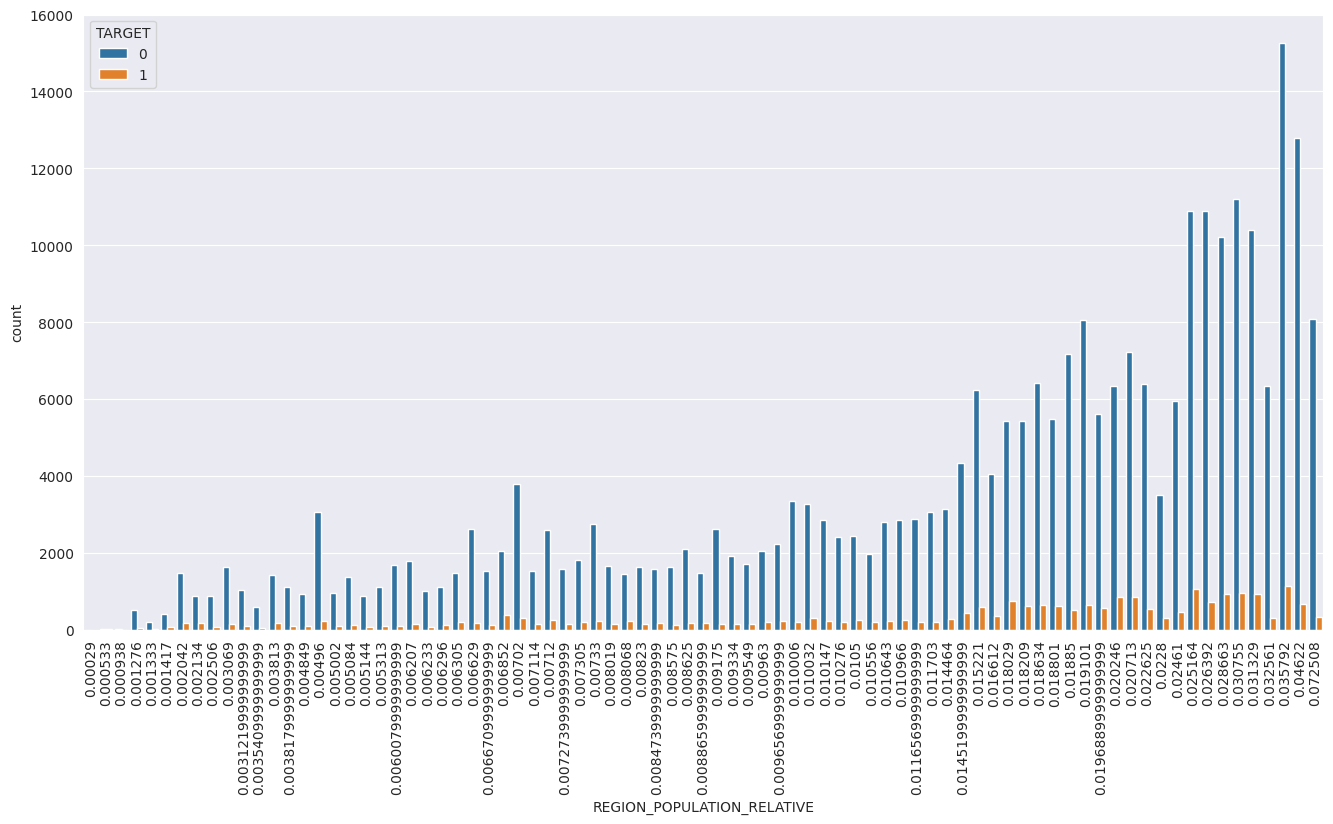

In [ ]:
fig,ax = plt.subplots(figsize=(16,8))
sns.countplot(data=appl_train,x='REGION_POPULATION_RELATIVE',hue='TARGET',ax=ax);
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.catplot(data=appl_train,x='WEEKDAY_APPR_PROCESS_START',hue='TARGET',kind='count');
plt.xticks(rotation=90);

ValueError: Could not interpret value `WEEKDAY_APPR_PROCESS_START` for `x`. An entry with this name does not appear in `data`.

In [ ]:
fig,ax = plt.subplots(figsize=(10,3))
sns.countplot(data=appl_train,x='HOUR_APPR_PROCESS_START',hue='TARGET',ax=ax);
plt.xticks(rotation=90)
plt.show()

Observations:
* REGION_POPULATION_RELATIVE has min val = 0.00029 and max val = 0.072508. Normalized values usually range from 0 to 1, but for this sample, the maximum value is way too far from 1. Whatever values this may serve, there is a noticeable number of defaults as the value gets higher.
* Majority of the customers apply during weekdays, with a few on weekends. The trend on customers who weren't able to repay the loan is similar with that of those who did.
* Suspiciously, there are people applying for a loan account as early as 3am, and it gets denser throughout the day. Do note that those who defaulted on their loan has a similar pattern with those having good records.

Decisions:
* Use REGION_POPULATION_RELATIVE as a feature model. The larger the population on a certain region, the more chances of getting a customer with a bad record.
* Drop WEEKDAY_APPR_PROCESS_START. I can't say that there's little chance of defaulting if the customer opens an account during Sundays, because the account opening overall on that day is relatively low compared to other days.
* Drop HOUR_APPR_PROCESS_START. Similar reasoning with above.

In [ ]:
# COLUMNS TO BE DROPPED
list_col_drop.extend(['WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START'])

In [ ]:
temp=appl_train[['TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]
print(temp.info())
sns.pairplot(temp,hue='TARGET');

Observations:
* These 3 fields are external data source score fields.
* Base on the plot above, those who were able to pay and did not pay can have scores fairly distributed on EXT_SOURCE fields, but it is quite evident that on the lower end of the normalized score mark (0.0-0.5), customers who paid (target=0, blue color) are much less prominent than those who didn't (target=1, orange color)... and vice versa.
* All 3 fields have missing values.

Decisions:
* Use EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 as model features.
* Complete the fields by filling up the null values base on their mean EXT_SOURCE.

In [ ]:
# COMPLETE COLUMNS : Base on mean EXT_SOURCE
list_col_fill_ext = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']

In [ ]:
appl_train[['AMT_INCOME_TOTAL','NAME_INCOME_TYPE','DAYS_EMPLOYED','OCCUPATION_TYPE','ORGANIZATION_TYPE']].describe(include='all')

In [ ]:
#Creating a Function for Threshold of the field, to find outliers
def get_thresh(df,field):
    """ Outliers are usually > 3 standard deviations away from the mean. """
    ave=np.mean(df[field])
    sdev=np.std(df[field])
    threshold=round(ave+(3*sdev),2)
    print('Threshold for',field,':',threshold)
    return threshold

In [ ]:
thresh_income = get_thresh(appl_train,'AMT_INCOME_TOTAL')
anomaly_emp = int(appl_train['DAYS_EMPLOYED'][appl_train['DAYS_EMPLOYED']>0].unique())
temp_orig=appl_train[['AMT_INCOME_TOTAL','DAYS_EMPLOYED']]
temp_no_outliers=appl_train[['AMT_INCOME_TOTAL','DAYS_EMPLOYED']][(appl_train.AMT_INCOME_TOTAL<thresh_income)&(appl_train['DAYS_EMPLOYED']<=0)]
print('Anomalous data for DAYS_EMPLOYED :',anomaly_emp)

In [ ]:
def plotdist(df,f1,f2):
    f,axes = plt.subplots(1,2,figsize=(10,3))
    sns.distplot(df[[f1]],ax=axes[0]).set_title(f1)
    plt.xticks(rotation=75)

    sns.distplot(df[[f2]],ax=axes[1]).set_title(f2)
    plt.xticks(rotation=75)
    plt.tight_layout()

In [ ]:
# AMT_INCOME_TOTAL, DAYS_EMPLOYED --> ORIGINAL VALUE WITH OUTLIERS
plotdist(temp_orig,'AMT_INCOME_TOTAL','DAYS_EMPLOYED')

In [ ]:
# AMT_INCOME_TOTAL, DAYS_EMPLOYED --> OUTLIERS REMOVED
plotdist(temp_no_outliers,'AMT_INCOME_TOTAL','DAYS_EMPLOYED')

In [ ]:
# NUMBER OF INDIVIDUALS HAVING THE DAYS EMPLOYED ANOMALOUS DATA
len(appl_train[appl_train.DAYS_EMPLOYED==anomaly_emp])

In [ ]:
unpaid=appl_train[appl_train.TARGET==1]
sns.catplot(data=unpaid,x='NAME_INCOME_TYPE',kind='count');
plt.xticks(rotation=90);
plt.title('Income Stream of DEFAULTED LOANS');

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
sns.countplot(data=unpaid,x='ORGANIZATION_TYPE',ax=ax);
plt.xticks(rotation=90)
plt.title('Organization of people with DEFAULTED LOANS')
plt.show()

In [ ]:
def plotstrip(df,xval,yval,hueval,yfig):
    fig,ax = plt.subplots(figsize=(15,yfig))
    sns.stripplot(x=xval,y=yval,hue=hueval,data=df,alpha=0.5,jitter=0.8,dodge=True,ax=ax).set_title(yval);
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

In [ ]:
temp=appl_train[appl_train.OCCUPATION_TYPE.isnull()]
print('Individuals that left OCCUPATION_TYPE field blank:')
print(temp.NAME_INCOME_TYPE.value_counts())

In [ ]:
plotstrip(appl_train[appl_train.AMT_INCOME_TOTAL<thresh_income],'AMT_INCOME_TOTAL','NAME_INCOME_TYPE','TARGET',5)

In [ ]:
plotstrip(appl_train[appl_train.AMT_INCOME_TOTAL<thresh_income],'AMT_INCOME_TOTAL','ORGANIZATION_TYPE','TARGET',20)

Observations:
* AMT_INCOME_TOTAL has an outlier. As per the data: the 75th percentile is equal to 202,500, while the maximum value is equal to a whopping 117,000,000; It is quite a big difference as it means that **75% of our customers** are already making a total income of **202,500 or below** - the remaining 25% has a total income higher than 202,500.
* AMT_INCOME_TOTAL has a wide range of values, from min val 25,650 to max val 117,000,000.
* DAYS_EMPLOYED is having inconsistent data. It contains negative values (since it is in the form of 'days' relative to the application), then suddenly there is one very big positive number (365243 days - which equates to 1000 years!) with a significant number of individuals having it.
* NAME_INCOME_TYPE: The 'working' category is the most dense in terms of low wage high default customers. We also have very few samples on 'unemployed', 'student', 'maternity leave' and 'businessman'. Interesting to see that the 'businessman' category has an above average total income and has a high chance that they will maintain good credit scoring.
* NAME_INCOME_TYPE 'Pensioner' is almost equal to the DAYS_EMPLOYED anomaly data count! And it is also almost equal to the ORGANIZATION_TYPE value 'XNA' ! It just means that the '1000 years' employment duration was made for retired people.
* OCCUPATION_TYPE has 31% of its values missing. Majority of the null OCCUPATION_TYPE are from pensioners (which totally makes sense), then other big chunks are from working people, commercial associate, state servant, etc. My take here is that the choices on occupation type field is limited which led these number of working people to leaving it blank.
* The ORGANIZATION_TYPE is pretty diverse regarding where do these customers work. But base on the histogram, the category where the defaulting individuals are dominant are those in Business Entity Type 3, self-employed, and XNA.

Decisions:
* AMT_INCOME_TOTAL: Create new feature 'IncomeBand' to convert into ordinal income band category.
* DAYS_EMPLOYED: Convert anomalous data 365243 days to -29200 days (equal to 80 yrs). I think it's safe to say that an individual is retired by then after working for 80 yrs. Create new feature 'years employed' to convert number of employed 'days' to 'years' for easier reading.
* OCCUPATION_TYPE: to drop. We can leverage on how much is their total stream of income and how they acquire it.
* NAME_INCOME_TYPE: to drop. We can usually identify if someone is working, or a student, or already retired, etc., base on the age and ORGANIZATION_TYPE.
* ORGANIZATION_TYPE: Convert categorical text to numerical. Use feature for modeling.

In [ ]:
# COLUMNS TO BE DROPPED
list_col_drop.extend(['OCCUPATION_TYPE','NAME_INCOME_TYPE'])

# CREATE NEW COLUMN : INCOME_BAND
list_col_new_income = ['AMT_INCOME_TOTAL']

# CONVERT COLUMN : 365243 to -29200
list_col_conv_daysemp = ['DAYS_EMPLOYED']

# CREATE NEW COLUMN : YEARS_EMPLOYED
list_col_new_yrsemp = ['DAYS_EMPLOYED']

# CONVERT COLUMN :
list_col_conv_org = ['ORGANIZATION_TYPE']

And for the final set of variables, I tagged it as 'trustworthiness' to account for trusthworthy credentials, or environmental/ unconsious factors that may shape an individual's behavior. It is quite a lot, so let's break it down again per function. (Note: the excel sheet above is incomplete as this notebook keeps crashing whenever I paste the remaining fields)

In [ ]:
appl_train[['CODE_GENDER','NAME_TYPE_SUITE','NAME_EDUCATION_TYPE','DAYS_REGISTRATION','DAYS_ID_PUBLISH']].describe(include='all')

In [ ]:
g = sns.FacetGrid(appl_train,row='CODE_GENDER',col='NAME_EDUCATION_TYPE',hue='TARGET',height=4) # nominal
g.map(plt.scatter,'DAYS_ID_PUBLISH','DAYS_REGISTRATION',alpha=0.5,edgecolor='k',linewidth=0.5) # continuous

fig = g.fig
fig.set_size_inches(25,10)
fig.subplots_adjust(top=0.85,wspace=0.3)
fig.suptitle('Gender - Educational Attainment - Registration Change - ID Change - Credit Ranking',fontsize=20)

l = g.add_legend(title='Credit Score')

In [ ]:
paid = appl_train[appl_train.TARGET==0]
unpaid = appl_train[appl_train.TARGET==1]

f,axes = plt.subplots(1,2,figsize=(10,3))
sns.kdeplot(x=paid['DAYS_ID_PUBLISH'], y=paid['DAYS_REGISTRATION'], cmap="Blues", shade=True, ax=axes[0]).set_title('Paid')
sns.kdeplot(x=unpaid['DAYS_ID_PUBLISH'], y=unpaid['DAYS_REGISTRATION'], cmap="Reds", shade=True, ax=axes[1]).set_title('Unpaid')
sns.set_style('whitegrid')
plt.tight_layout()

In [ ]:
appl_train.NAME_EDUCATION_TYPE.value_counts()

In [ ]:
f,axes = plt.subplots(1,2,figsize=(10,5),sharex=True)
sns.distplot(appl_train[['DAYS_BIRTH']][appl_train.TARGET==0],hist=False,color="b",kde_kws={"shade":True},ax=axes[0]).set_title('Target == 0 (Paid)');
sns.distplot(appl_train[['DAYS_BIRTH']][appl_train.TARGET==1],hist=False,color="r",kde_kws={"shade":True},ax=axes[1]).set_title('Target == 1 (Unpaid)');

Observations:
* We have 3 types of CODE_GENDER in our sample: Male, female and XNA. Male and female customers are pretty dense, both having same chances of defaulting relative to their total count. We have a very small set of XNA (non-binary?) people, and base on our sample, 100% of them have good credit record.
* For NAME_EDUCATION_TYPE, majority of our customers - whether male, female, or XNA - are having 'secondary special' or 'higher education', and most of the defaulting customers came from this educational background. 'Incomplete higher' and 'Lower secondary' are lesser with also less defaulting customers. And the least count are those with 'Academic degree' which got the least number of unpaid customers.
* The number of days in which the customer changed his/her identity document and/or application registration seemed to have the same pattern for those having good credit and bad credit.
* The DAYS_BIRTH of a customer (or rather the 'age') seem as expected. We can note that the x-axis values are negative - because it is recorded relative prior to the loan application - and very high (because it is in 'days' format rather than in 'years'). As per the graph, younger people tend to default more. As people gets older, they seem to be able to have a higher chance of paying off the loan.

Decisions:
* Use CODE_GENDER as a model feature. Convert the categorical text to numeric.
* Use NAME_EDUCATION_TYPE as a model feature. Convert the categorical text to numeric.
* Drop DAYS_REGISTRATION, DAYS_ID_PUBLISH, NAME_TYPE_SUITE. I generated a KDE plot and I hardly see the difference.
* Create new feature 'age' from DAYS_BIRTH. Compute for the age in years rather than using the day count.

In [ ]:
# COLUMNS TO BE DROPPED
list_col_drop.extend(['NAME_TYPE_SUITE','DAYS_REGISTRATION','DAYS_ID_PUBLISH'])

# CONVERT COLUMN :
list_col_conv_gender = ['CODE_GENDER']

# CONVERT COLUMN :
list_col_conv_edu = ['NAME_EDUCATION_TYPE']

# CREATE NEW COLUMN : AGE
list_col_new_age = ['DAYS_BIRTH']


In [ ]:
temp1=['FLAG_MOBIL',
'FLAG_EMP_PHONE',
'FLAG_WORK_PHONE',
'FLAG_CONT_MOBILE',
'FLAG_PHONE',
'FLAG_EMAIL']

temp2=['FLAG_DOCUMENT_2',
'FLAG_DOCUMENT_3',
'FLAG_DOCUMENT_4',
'FLAG_DOCUMENT_5',
'FLAG_DOCUMENT_6',
'FLAG_DOCUMENT_7',
'FLAG_DOCUMENT_8',
'FLAG_DOCUMENT_9',
'FLAG_DOCUMENT_10',
'FLAG_DOCUMENT_11',
'FLAG_DOCUMENT_12',
'FLAG_DOCUMENT_13',
'FLAG_DOCUMENT_14',
'FLAG_DOCUMENT_15',
'FLAG_DOCUMENT_16',
'FLAG_DOCUMENT_17',
'FLAG_DOCUMENT_18',
'FLAG_DOCUMENT_19',
'FLAG_DOCUMENT_20',
'FLAG_DOCUMENT_21']

In [ ]:
appl_train[temp1+temp2].describe()

In [ ]:
#Sums up items per row across all columns. Returns df with new sum column and catplot.
def featsum(cols,newcol):

    sample_count=appl_train[cols].sum(axis=1)
    sample = appl_train.copy()
    sample[newcol]=sample_count
    sns.catplot(data=sample,x=newcol,hue='TARGET',kind='count');

In [ ]:
featsum(temp1,'FlagContact')

In [ ]:
featsum(temp2,'FlagDocu')

Observations:
* All 26 'FLAG-' (flag for contacts and documents) variables have nominal categorical values: 1='YES', 0='NO'.

Decisions:
* Create new feature 'FlagContact' to account for the total flag-contact variable recorded per individual.
* Create new feature 'FlagDocu' to account for the total flag-document variable recorded per individual.

In [ ]:
# CREATE NEW COLUMN : FLAG_CONTACTS
list_col_new_flagCont = [
    'FLAG_MOBIL',
    'FLAG_EMP_PHONE',
    'FLAG_WORK_PHONE',
    'FLAG_CONT_MOBILE',
    'FLAG_PHONE',
    'FLAG_EMAIL']

# CREATE NEW COLUMN : FLAG_DOCS
list_col_new_flagDoc = [
    'FLAG_DOCUMENT_2',
    'FLAG_DOCUMENT_3',
    'FLAG_DOCUMENT_4',
    'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6',
    'FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8',
    'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10',
    'FLAG_DOCUMENT_11',
    'FLAG_DOCUMENT_12',
    'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14',
    'FLAG_DOCUMENT_15',
    'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18',
    'FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20',
    'FLAG_DOCUMENT_21']

In [ ]:
#Function for creating categorical plots
def plotcat(x,r):
    sns.catplot(data=appl_train,x=x,hue='TARGET',kind='count');
    plt.xticks(rotation=r);

In [ ]:
plotcat('REGION_RATING_CLIENT',0)

In [ ]:
plotcat('REGION_RATING_CLIENT_W_CITY',0)

In [ ]:
print('Correlation:',round(appl_train['REGION_RATING_CLIENT_W_CITY'].corr(appl_train['REGION_RATING_CLIENT']),2))

In [ ]:
temp=[
    'REG_REGION_NOT_LIVE_REGION',
    'LIVE_REGION_NOT_WORK_REGION',
    'REG_CITY_NOT_LIVE_CITY',
    'LIVE_CITY_NOT_WORK_CITY'
]

In [ ]:
featsum(temp,'FlagAddr')

Observations:
* REGION_RATING_CLIENT & REGION_RATING_CLIENT_W_CITY is highly correlated, scoring 0.95. This is Home Credit's rating of the region where client lives (values = 1,2,3). Majority of the sample obtains a value of '2', and the defaulting count is visible
* The 4 fields related to flags if the customer's certain (registered) address does not match another given address, the values being: 0='SAME', 1='DIFFERENT'. Most of the customers registered their addresses accurately (scoring 0). And since '0' has a very high frequency, there is a greater chance of encountering different kinds of people that may default on their loan.

Decisions:
* Use REGION_RATING_CLIENT as a feature model.
* Drop REGION_RATING_CLIENT_W_CITY since it is highly correlated to region rating alone.
* Create new ordinal feature 'flag address' to indicate the sum of all 4 flag-address-related fields. The higher the score, the more inaccurate address declarations were made by the individual.


In [ ]:
# COLUMNS TO BE DROPPED
list_col_drop.extend(['REGION_RATING_CLIENT_W_CITY'])

# CREATE NEW COLUMN : FLAG_ADDR
list_col_new_flagAddr = ['REG_REGION_NOT_LIVE_REGION','LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','LIVE_CITY_NOT_WORK_CITY']

In [ ]:
appl_train[['OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','DAYS_LAST_PHONE_CHANGE']].describe()

In [ ]:
#Sums up items per row across all columns.Returns df with new sum column and violinplot.
def featsumviolin(df,cols1,cols2,newcol1,newcol2):

    sample_count1=df[cols1].sum(axis=1)
    sample_count2=df[cols2].sum(axis=1)
    sample = appl_train.copy()
    sample[newcol1]=sample_count1
    sample[newcol2]=sample_count2
    fig,ax = plt.subplots(figsize=(10,5))
    sns.violinplot(data=sample,hue='TARGET',x=newcol1,y=newcol2,split=True,inner='quart',linewidth=1.3,palette={1:"#FF9999", 0:"white"});

In [ ]:
featsumviolin(appl_train[(appl_train.OBS_30_CNT_SOCIAL_CIRCLE<348)&(appl_train.OBS_60_CNT_SOCIAL_CIRCLE<344)],
              ['DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE'],
              ['OBS_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE'],
              'DEF_NEW','OBS_NEW')

In [ ]:
sns.set(palette="muted",color_codes=True)
f,axes = plt.subplots(2,2,figsize=(10,5),sharex=True)

sns.distplot(appl_train[['DAYS_LAST_PHONE_CHANGE']][appl_train.TARGET==0],kde=False,color="b",ax=axes[0,0]).set_title('Target == 0 (Paid)')
sns.distplot(appl_train[['DAYS_LAST_PHONE_CHANGE']][appl_train.TARGET==0],hist=False,color="g",kde_kws={"shade":True},ax=axes[0,1]).set_title('Target == 0 (Paid)')

sns.distplot(appl_train[['DAYS_LAST_PHONE_CHANGE']][appl_train.TARGET==1],kde=False,color="r",ax=axes[1,0]).set_title('Target == 1 (Unpaid)')
sns.distplot(appl_train[['DAYS_LAST_PHONE_CHANGE']][appl_train.TARGET==1],hist=False,color="m",kde_kws={"shade":True},ax=axes[1,1]).set_title('Target == 1 (Unpaid)')

plt.tight_layout()

Observations:
* There are 2 variables related to 30 days past due (30 DPD), and another 2 for 60 days past due (60 DPD). I have combined them and plotted using a violinplot as seen above. From what I understand here, those people that defaulted, and even those who didn't, have equal possibilities of missing a payment on their due date. Though surprisingly, majority of those who paid on a much later date got their loans cleared off.
> Note: A payment status of 30-days late means that payment is between 30-59 days past the payment due date (30 DPD). A payment status of 60-days late means that payment is between 60-89 days past the payment due date (60 DPD).
* I plotted separately the days in which a customer last changed their phone (relative to their application) for those having good and bad loan status records. The result is pretty much expected, as most people tend to change phones in a span of 2-3 years only (hence the distribution is skewed to the right). We can see that the people count gets lesser and lesser as the usage of their phone gets longer than the average.

Decisions:
* Drop the DPD variables.
* Drop DAYS_LAST_PHONE_CHANGE.

In [ ]:
# COLUMNS TO BE DROPPED
list_col_drop.extend(['OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','DAYS_LAST_PHONE_CHANGE'])

In [ ]:
appl_train[['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']].describe()

In [ ]:
for i in ['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK']:
    for j in ['AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']:
        fig,ax = plt.subplots(figsize=(10,3))
        sns.stripplot(data=appl_train[appl_train.AMT_REQ_CREDIT_BUREAU_QRT<261],x=i,y=j,hue='TARGET',alpha=0.5,jitter=0.3,dodge=True,ax=ax)
        plt.show()

Observations:
* What I can see here is that, majority of the sample don't really have queries (0.0) regardless what time period it is, and regardless of their repayment status. The most common enquiry count ranges from 0 to 2, but then the behavior is similar to both TARGET==0 and TARGET==1. Do take note that we only have a few individuals (about 8%) in our sample population that defaulted (TARGET==1).

Decisions:
* Drop the credit bureau enquiry fields.

In [ ]:
# COLUMNS TO BE DROPPED
list_col_drop.extend(['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR'])

# 6. Data Wrangling

After (finally) checking all our fields, it is time to proceed with data wrangling - also known as the data cleaning process.

Complete the null values of the following features:
* 'EXT_SOURCE_1'
* 'EXT_SOURCE_2'
* 'EXT_SOURCE_3'

In [ ]:
#Essential Functions
def getmean(df,ls_cols):
    list_mean = []
    for i in ls_cols:
        mean_val = df[i].mean()
        list_mean.append(mean_val)
    return list_mean

def fill_ave_ext(df,ls_cols):
    list_mean = getmean(df,ls_cols) # mean of EXT_SOURCE_*
    ctr=0
    for i in ls_cols:
        df[i] = df[i].fillna(list_mean[ctr])
        ctr+=1
    return df

# Fill in the training set
fill_ave_ext(appl_train,list_col_fill_ext);

# Fill in the testing set
fill_ave_ext(appl_test,list_col_fill_ext);

In [ ]:
# NO MORE NULL VALUES FOR 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'
print(appl_train[list_col_fill_ext].info())
print(appl_test[list_col_fill_ext].info())

Complete the null values for 'CNT_FAM_MEMBERS'.

In [ ]:
#Complete the null values for 'CNT_FAM_MEMBERS'.
def fill_0_fam(df,ls_cols):
    df[ls_cols] = df[ls_cols].fillna(0)
    return df


fill_0_fam(appl_train,'CNT_FAM_MEMBERS');
fill_0_fam(appl_test,'CNT_FAM_MEMBERS');

In [ ]:
# NO MORE NULL VALUES FOR 'CNT_FAM_MEMBERS'
print(appl_train[list_col_fill_fam].info())
print(appl_test[list_col_fill_fam].info())

Convert the anomaly data in 'DAYS_EMPLOYED'.

In [ ]:
# ANOMALY DATA COUNT BEFORE CONVERSION
print('Train set :',len(appl_train[appl_train.DAYS_EMPLOYED==365243]))
print('Test set  :',len(appl_test[appl_test.DAYS_EMPLOYED==365243]))

In [ ]:
def conv_daysemp(df,ls_cols):
    df[ls_cols[0]].replace(to_replace=365243,value=-29200,inplace=True)
    return df

In [ ]:
conv_daysemp(appl_train,list_col_conv_daysemp);
conv_daysemp(appl_test,list_col_conv_daysemp);

In [ ]:
# ANOMALY DATA COUNT AFTER CONVERSION
print('Train set :',len(appl_train[appl_train.DAYS_EMPLOYED==365243]))
print('Test set  :',len(appl_test[appl_test.DAYS_EMPLOYED==365243]))

Convert the categorical text columns to numerical ones for:
* CODE_GENDER
* NAME_EDUCATION_TYPE
* ORGANIZATION_TYPE

In [ ]:
# BEFORE CONVERSION
print(appl_train[['CODE_GENDER','NAME_EDUCATION_TYPE','ORGANIZATION_TYPE']].head(3))
print(appl_test[['CODE_GENDER','NAME_EDUCATION_TYPE','ORGANIZATION_TYPE']].head(3))

In [ ]:
def conv_gender(df,ls_cols):
    df[ls_cols[0]] = df[ls_cols[0]].map({'XNA':0,'M':1,'F':2}).astype(int)
    return df

def conv_education(df,ls_cols):
    temp_dict = {
        'Lower secondary':1,
        'Secondary / secondary special':2,
        'Incomplete higher':3,
        'Higher education':4,
        'Academic degree':5
    }
    df[ls_cols[0]] = df[ls_cols[0]].map(temp_dict).astype(int)
    return df

def conv_org(df,ls_cols):
    ls_ctr=[i for i in np.arange(1,len(ls_cols)+1)]
    temp_dict = dict(zip(ls_cols,ls_ctr))
    df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].map(temp_dict).astype(int)
    return df

In [ ]:
conv_gender(appl_train,list_col_conv_gender);
conv_gender(appl_test,list_col_conv_gender);

conv_education(appl_train,list_col_conv_edu);
conv_education(appl_test,list_col_conv_edu);

In [ ]:
orgtype = sorted(appl_train.ORGANIZATION_TYPE.unique())
conv_org(appl_train,orgtype);
conv_org(appl_test,orgtype);

In [ ]:
# AFTER CONVERSION
print(appl_train[['CODE_GENDER','NAME_EDUCATION_TYPE','ORGANIZATION_TYPE']].head(3))
print(appl_test[['CODE_GENDER','NAME_EDUCATION_TYPE','ORGANIZATION_TYPE']].head(3))

# 7. Hypothesis Testing

#7.1 Debt-to-Income Ratio and Income per Child
###Hypothesis: Users with higher education levels have higher average income.

1. **Null Hypothesis (H0):**

    There is no significant difference in the Debt-to-Income Ratio based on the Income per Child.

2. **Alternative Hypothesis (H1):**

  The Debt-to-Income Ratio significantly varies based on the Income per Child.

3. **Test:**
    
    Pearson Correlation Coefficient.
4. **Reason for chosing this Test:**

    The Pearson correlation coefficient is appropriate for assessing the strength and direction of the linear relationship between two continuous variables, in this case, the Debt-to-Income Ratio and Income per Child.

In [ ]:
# Create new features
appl_train['debt_income_ratio'] = appl_train['AMT_CREDIT'] / appl_train['AMT_INCOME_TOTAL']
appl_train['income_per_child'] = appl_train['AMT_INCOME_TOTAL'] / (1 + appl_train['CNT_CHILDREN'])

# Step 1: Define significance level
alpha = 0.05

# Step 2: Calculate the Pearson correlation and p-value
correlation, p_value = stats.pearsonr(appl_train['debt_income_ratio'], appl_train['income_per_child'])

# Step 3: Print the results
print(f"Pearson correlation coefficient: {correlation}")
print(f"p-value: {p_value}")

# Step 4: Hypothesis Testing
if p_value <= alpha:
    print("Reject the null hypothesis: Significant correlation exists.")
else:
    print("Fail to reject the null hypothesis: No significant correlation exists.")

##Debt-to-Income Ratio by Default Status
Visualize the distribution of the debt-to-income ratio across default and non-default users.

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(x='debt_income_ratio', hue='TARGET', data=appl_train, bins=50, kde=True, palette=['blue', 'white'])
plt.xlim(0, 20)
plt.title('Debt to Income Ratio by Default Status')
plt.xlabel('Debt to Income Ratio')

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='debt_income_ratio', y='income_per_child', data=appl_train)
plt.title('Scatter Plot of Debt-to-Income Ratio vs. Income per Child')
plt.xlabel('Debt-to-Income Ratio')
plt.ylabel('Income per Child')
plt.axhline(0, color='red', linestyle='--')  # Optional: Add a horizontal line for reference
plt.axvline(0, color='red', linestyle='--')  # Optional: Add a vertical line for reference

##Hypothesis Conclusion:

Based on the analysis conducted using the Pearson correlation test, we calculated a Pearson correlation coefficient of approximately -0.137 between the debt-to-income ratio and income per child, indicating a weak negative correlation. The p-value obtained is 0.0, which is significantly lower than our chosen significance level of 0.05. Therefore, we reject the null hypothesis and conclude that there is a significant correlation between the debt-to-income ratio and income per child. This suggests that as the debt-to-income ratio changes, there is a statistically significant change in the income per child.

#7.2 Income Level and Default Likelihood
###Hypothesis: Users with lower income levels are more likely to default.

1. **Null Hypothesis (H0):**

    There is no significant difference in income levels between users who default and those who do not.

2. **Alternative Hypothesis (H1):**

  There is a significant difference in income levels between users who default and those who do not.

3. **Test:**
    
    Independent Samples T-Test.
4. **Reason for chosing this Test:**

    Independent Samples T-Test is appropriate for comparing the means of two independent group users who default and those who do not—to determine if income levels significantly differ between the two groups.

In [ ]:
# Split income data based on target variable
defaulted_income = appl_train[appl_train['TARGET'] == 1]['AMT_INCOME_TOTAL']
non_defaulted_income = appl_train[appl_train['TARGET'] == 0]['AMT_INCOME_TOTAL']

# Perform T-test
t_stat, p_val = ttest_ind(defaulted_income, non_defaulted_income, equal_var=False)
print("T-Test for Income Levels and Default Likelihood")
print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_val:.4f}")

In [ ]:
plt.figure(figsize=(12, 6))

# Box Plot
plt.subplot(1, 2, 1)
sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=appl_train, palette='pastel')
plt.title('Box Plot of Income Levels by Default Status')
plt.xlabel('Default Status (0 = No Default, 1 = Default)')
plt.ylabel('Income Level (Total Income)')

# Violin Plot
plt.subplot(1, 2, 2)
sns.violinplot(x='TARGET', y='AMT_INCOME_TOTAL', data=appl_train, palette='pastel')
plt.title('Violin Plot of Income Levels by Default Status')
plt.xlabel('Default Status (0 = No Default, 1 = Default)')
plt.ylabel('Income Level (Total Income)')
plt.tight_layout()

##Hypothesis Conclusion:

The Independent Samples T-Test revealed a T-Statistic of **-0.7307** and a P-Value of **0.4650**. Since the P-Value is significantly higher than the common significance level of 0.05, we fail to reject the null hypothesis (H0).

This indicates that there is no significant difference in income levels between users who default and those who do not. Therefore, we conclude that income level does not appear to be a significant factor influencing loan default likelihood in this analysis.

#7.3 Education Level and Income
###Hypothesis: Users with higher education levels have higher average income.

1. **Null Hypothesis (H0):**

    There is no significant difference in income based on education level.

2. **Alternative Hypothesis (H1):**

  Income significantly varies by education level.

3. **Test:**
    
    ANOVA (Analysis of Variance).
4. **Reason for chosing this Test:**

    ANOVA (Analysis of Variance) is chosen to assess whether there are significant differences in average income across multiple education levels, as it effectively compares means among three or more independent groups.

In [ ]:
education_groups = [group['AMT_INCOME_TOTAL'].values for name, group in appl_train.groupby('NAME_EDUCATION_TYPE')]

# Perform ANOVA
f_stat, p_val = f_oneway(*education_groups)

# Print ANOVA results
print("ANOVA for Income by Education Level")
print(f"F-Statistic: {f_stat:.4f}, P-Value: {p_val:.4f}")

# Visualization: Box Plot for Income by Education Level
plt.figure(figsize=(12, 6))
sns.boxplot(x='NAME_EDUCATION_TYPE', y='AMT_INCOME_TOTAL', data=appl_train, palette='pastel')
plt.title('Box Plot of Income by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Income Level (Total Income)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

##Hypothesis Conclusion:

The ANOVA analysis for income by education level yielded an F-Statistic of 753.2160 and a P-Value of 0.0000. Since the P-Value is significantly lower than the common significance level of 0.05, we reject the null hypothesis (H0).

This indicates that there is a significant difference in income based on education level. Consequently, we conclude that users with varying education levels have different average income levels, supporting the hypothesis that higher education levels are associated with higher average incomes.

#7.4 Employment Length and Default Likelihood
###Hypothesis: Users with shorter employment durations are more likely to default.

1. **Null Hypothesis (H0):**

    There is no significant difference in employment duration between users who default and those who do not.

2. **Alternative Hypothesis (H1):**

  There is a significant difference in employment duration between users who default and those who do not.

3. **Test:**
    
    Independent Samples T-Test.
4. **Reason for chosing this Test:**

    The Independent Samples T-Test is suitable for comparing the means of two independent groups users who default and those who do not—to determine if there is a significant difference in employment length between the two groups.

In [ ]:
defaulted_emp = appl_train[appl_train['TARGET'] == 1]['DAYS_EMPLOYED'].abs()
non_defaulted_emp = appl_train[appl_train['TARGET'] == 0]['DAYS_EMPLOYED'].abs()

# Perform T-test
t_stat, p_val_emp = ttest_ind(defaulted_emp, non_defaulted_emp, equal_var=False)
print("T-Test for Employment Length and Default Likelihood")
print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_val_emp:.4f}")

# Visualization: Box Plot for Employment Length by Default Status
plt.figure(figsize=(12, 6))
sns.boxplot(x='TARGET', y='DAYS_EMPLOYED', data=appl_train, palette='pastel')
plt.title('Box Plot of Employment Length by Default Status')
plt.xlabel('Default Status (0 = No Default, 1 = Default)')
plt.ylabel('Employment Length (Days)')
plt.xticks(ticks=[0, 1], labels=['Non-Defaulted', 'Defaulted'])
plt.tight_layout()
plt.show()

# Interpretation
if p_val_emp < 0.05:
    print("Result: Reject the null hypothesis (significant difference in employment length between groups).")
else:
    print("Result: Fail to reject the null hypothesis (no significant difference in employment length).")


##Hypothesis Conclusion:

The T-Test for Employment Length and Default Likelihood yielded a T-Statistic of -37.4471 and a P-Value of 0.0000. Since the P-Value is significantly lower than the common significance level of 0.05, we reject the null hypothesis (H0).

This indicates that there is a significant difference in employment length between users who default and those who do not. Therefore, we conclude that users with shorter employment durations are indeed more likely to default.


#7.5 Number of Children and Default Likelihood

###Hypothesis: Users with more children are more likely to default.

1. **Null Hypothesis (H0):**

    There is no association between the number of children and default likelihood.

2. **Alternative Hypothesis (H1):**

  There is an association between the number of children and default likelihood.

3. **Test:**
    
    Chi-Square Test
4. **Reason for chosing this Test:**

    The Chi-Square Test for Independence is appropriate for assessing the relationship between two categorical variables—in this case, the number of children and default status—to determine if the distribution of defaults varies based on the number of children users have.

In [ ]:
children_contingency = pd.crosstab(appl_train['CNT_CHILDREN'], appl_train['TARGET'])

# Perform Chi-Square test
chi2, p_val_children, dof, expected = chi2_contingency(children_contingency)
print("Chi-Square Test for Number of Children and Default Likelihood")
print(f"Chi2 Statistic: {chi2:.4f}, P-Value: {p_val_children:.4f}")

# Visualization: Bar Plot for Number of Children by Default Status
plt.figure(figsize=(12, 6))
children_contingency.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'])
plt.xlim(0,6)
plt.title('Default Status by Number of Children')
plt.xlabel('Number of Children')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.legend(title='Default Status', labels=['Non-Defaulted (0)', 'Defaulted (1)'])
plt.tight_layout()

# Interpretation
if p_val_children < 0.05:
    print("Result: Reject the null hypothesis (significant association between number of children and default likelihood).")
else:
    print("Result: Fail to reject the null hypothesis (no significant association).")

##Hypothesis Conclusion:

The Chi-Square Test for Number of Children and Default Likelihood yielded a Chi2 Statistic of 185.4518 and a P-Value of 0.0000. Since the P-Value is significantly lower than the common significance level of 0.05, we reject the null hypothesis (H0).

This indicates that there is a significant association between the number of children users have and their likelihood of defaulting on loans. Therefore, we conclude that users with more children are indeed more likely to default. This finding highlights the potential impact of family size on financial stability and default risk.

#7.6 Annuity Amount and Loan Default
###Hypothesis: Higher annuity amounts are associated with a higher likelihood of default.

1. **Null Hypothesis (H0):**

    There is no significant difference in annuity amount between users who default and those who don’t.

2. **Alternative Hypothesis (H1):**

  There is a significant difference in annuity amount between users who default and those who don’t.

3. **Test:**
    
    Independent Samples T-Test on AMT_ANNUITY.
4. **Reason for chosing this Test:**

    The Independent Samples T-Test is suitable for comparing the means of two independent groups users who default and those who do not—to determine if there is a significant difference in employment length between the two groups.

In [ ]:
# Separate annuity data for defaulted and non-defaulted users
defaulted_annuity = appl_train[appl_train['TARGET'] == 1]['AMT_ANNUITY']
non_defaulted_annuity = appl_train[appl_train['TARGET'] == 0]['AMT_ANNUITY']

# Perform T-test
t_stat, p_val_annuity = ttest_ind(defaulted_annuity.dropna(), non_defaulted_annuity.dropna(), equal_var=False)
print("T-Test for Annuity Amount and Default Likelihood")
print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_val_annuity:.4f}")

plt.figure(figsize=(8, 5))
sns.histplot(data=appl_train, x='AMT_ANNUITY', hue='TARGET', bins=50, kde=True, palette='coolwarm')
plt.title("Annuity Amount Distribution by Default Status")
plt.xlim(0,100000)
plt.xlabel("Annuity Amount")
plt.ylabel("Frequency")
plt.legend(title='Default Status', labels=['Non-Defaulted (0)', 'Defaulted (1)'])
plt.tight_layout()

# Interpretation
if p_val_annuity < 0.05:
    print("Result: Reject the null hypothesis (significant difference in annuity amount between groups).")
else:
    print("Result: Fail to reject the null hypothesis (no significant difference in annuity amount).")

##Hypothesis Conclusion:

The T-Test for Annuity Amount and Default Likelihood resulted in a T-Statistic of -8.1473 and a P-Value of 0.0000. Since the P-Value is significantly less than the standard significance level of 0.05, we reject the null hypothesis (H0).

This indicates a significant difference in annuity amounts between users who default and those who do not. Therefore, we conclude that higher annuity amounts are indeed associated with a higher likelihood of default, suggesting that annuity amounts are an important factor in evaluating the risk of default among users.